<a href="https://colab.research.google.com/github/ClaudiaEspo/isbi-dashboard/blob/main/Prog_isbi_vers_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Traccia homework 2**


Ci troviamo nel caso in cui vogliamo predirre il numero di infestanti (insetti) catturati, oppure la loro insorgenza  utilizzando dati metereologici unitamente all'insorgenza degli stessi in intervalli di tempo precedenti

Variabile Target:

Problema di Regressione: NUMERO D'INSETTI CATTURATI

Problema di Classificazione : NUOVE CATTURE

Utilizzare Python e le librerie che si ritiene più opportuno, tra cui streamlit per la creazione della dashboard (totale libertà sugli strumenti da utilizzare)




# **Introduzione**

Un **problema di classificazione** è riuscire a trovare tra diverse classi quella corretta per il nostro campione di dati. La modellazione predittiva di classificazione consente di approssimare una funzione di mappatura da variabili in ingresso a variabili di uscita discrete. Se le classi sono due, parliamo di problema di classificazione binaria.

La modellazione predittiva di regressione consiste nell'approssimare una funzione di mappatura dalle variabili di ingresso a una variabile di uscita continua. Ad esempio si può determinare come andranno le vendite di un determinato prodotto, basandosi su analisi degli anni precedenti e sull'andamento generale del mercato. Un problema di regressione in cui le variabili input sono ordinate in base al tempo è chiaamto **problema di previsione delle serie temporali**.

*Di seguito, si importano tutte le librerie necessarie*

In [ ]:
import warnings
warnings.filterwarnings('ignore')



import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns



from scipy.stats import kstest, ks_2samp
from statsmodels.tsa.stattools import adfuller



from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score


from scipy.stats import gaussian_kde

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler


import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

*Dal Drive estraiamo 4 file excel su Cicalino: 2 riguardo i dati meterologici e 2 sulle catture degli insetti.*




---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/dati/dati-meteo-storici (Cicalino 1).xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/dati/dati-meteo-storici (Cicalino 2).xlsx')
df3 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/dati/grafico-delle-catture (Cicalino 1).xlsx')
df4 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/dati/grafico-delle-catture (Cicalino 2).xlsx')

#**Preparazione dei dati**





Per le successive elaborazioni è necessario che la colonna "DateTime", contenente giorno e ora, diventi l'indice dei Dataframe.

In [ ]:
df1["DateTime"] = pd.to_datetime(df1["DateTime"], format="%d.%m.%Y %H:%M:%S", errors='coerce')
df2['DateTime'] = pd.to_datetime(df2['DateTime'], format="%d.%m.%Y %H:%M:%S", errors='coerce')
df3['DateTime'] = pd.to_datetime(df3['DateTime'], format="%d.%m.%Y %H:%M:%S", errors='coerce')
df4['DateTime'] = pd.to_datetime(df4['DateTime'], format="%d.%m.%Y %H:%M:%S", errors='coerce')

df1.index = df1.DateTime
del df1["DateTime"]

df2.index = df2.DateTime
del df2["DateTime"]

df3.index = df3.DateTime
del df3["DateTime"]

df4.index = df4.DateTime
del df4["DateTime"]

Abbiamo i DataFrame *df1* e *df2*, che contengono rispettivamente i dati di temperatura e umidità per ogni giorno e ora. Poiché vogliamo lavorare considerando solo le ore, abbiamo fatto il resample dell'indice per raggruppare i dati in base al giorno, calcolando la media dei 24 valori giornalieri per ciascuna ora. Da questo momento *df1_daily* e *df2_daily* conterranno la media della Temperatura e dell'Umidità giornaliera.

In [ ]:
df1_daily = df1.resample('D').mean()
df2_daily = df2.resample('D').mean()

In [ ]:
print(df1_daily.head(15))
print(df2_daily.head(15))

            Media Temperatura  Media Umidità
DateTime                                    
2024-07-05          25.777778      56.674444
2024-07-06          22.342500      72.247500
2024-07-07          23.517917      76.728750
2024-07-08          25.669167      69.143750
2024-07-09          25.870000      53.647083
2024-07-10          26.410000      58.943750
2024-07-11          26.262500      54.386250
2024-07-12          26.169583      57.745417
2024-07-13          25.491667      69.137083
2024-07-14          25.960417      68.728750
2024-07-15          26.975833      57.115833
2024-07-16          26.463333      55.910000
2024-07-17          27.664583      55.034167
2024-07-18          27.054167      52.113750
2024-07-19          27.716667      54.536667
            Media Temperatura  Media Umidità
DateTime                                    
2024-07-11          26.166522      56.061739
2024-07-12          26.557917      57.273750
2024-07-13          25.907917      67.642083
2024-07-14

Poiché i due DataFrame presentano una parziale sovrapposizione, li concateneremo e calcoleremo la media tra i valori sovrapposti.

In [ ]:
df_merged = pd.concat([df1_daily, df2_daily])
df_merged  = df_merged.groupby(df_merged.index).mean()
print(df_merged.head())

            Media Temperatura  Media Umidità
DateTime                                    
2024-07-05          25.777778      56.674444
2024-07-06          22.342500      72.247500
2024-07-07          23.517917      76.728750
2024-07-08          25.669167      69.143750
2024-07-09          25.870000      53.647083


La funzione `normalize` viene utilizzata per rimuovere la componente oraria da un indice di tipo `DateTime`. Nel nostro caso, applichiamo questa funzione ai DataFrame relativi alle catture di insetti, poiché l'obiettivo è creare un codice per la previsione giornaliera, dove la componente oraria non è rilevante.

In [ ]:
df3.index = df3.index.normalize()
df4.index = df4.index.normalize()

Eliminiamo le colonne superflue dai DataFrame e sostituiamo i valori `NaN` con `0`. I valori `NaN` si trovano in corrispondenza degli eventi di cleaning, che abbiamo considerato non particolarmente rilevanti per la nostra analisi.

**GIUSTIFICARE PERCHè ABBIAMO TOLTO LE COLONNE DI RECENSITO ED EVENTO**

In [ ]:
df3 = df3.drop(columns=['Recensito', 'Evento'])
df4 = df4.drop(columns=['Recensito', 'Evento'])

In [ ]:
df3 = df3.fillna(0)
df4 = df4.fillna(0)

In [ ]:
print(df3.head())
print(df4.head())

            Numero di insetti  Nuove catture (per evento)
DateTime                                                 
2024-07-06                0.0                         0.0
2024-07-07                0.0                         0.0
2024-07-08                0.0                         0.0
2024-07-09                0.0                         0.0
2024-07-09                0.0                         0.0
            Numero di insetti  Nuove catture (per evento)
DateTime                                                 
2024-07-05                0.0                         0.0
2024-07-06                0.0                         0.0
2024-07-07                0.0                         0.0
2024-07-08                0.0                         0.0
2024-07-08                0.0                         0.0


*df_merged2* è il risultato della concatenazione di *df3* e *df4*. Questo DataFrame contiene la somma giornaliera delle colonne *Numero di insetti* e *Nuove catture (per evento)*.

In [ ]:
df_merged2 = pd.concat([df3, df4])
df_merged2  = df_merged2.groupby(df_merged2.index).sum()
print(df_merged2.head())


            Numero di insetti  Nuove catture (per evento)
DateTime                                                 
2024-07-05                0.0                         0.0
2024-07-06                0.0                         0.0
2024-07-07                0.0                         0.0
2024-07-08                0.0                         0.0
2024-07-09                0.0                         0.0


A questo punto, disponiamo dei DataFrame *df_merged* e *df_merged2*. Procediamo con la funzione *inspect_dataset* per raccogliere informazioni utili, come il numero di righe e colonne duplicate, il conteggio dei valori nulli presenti in ogni colonna e l'uso della memoria.

In [ ]:
def inspect_dataset(df):
    info = df.info()   #fornisce il tipo di oggetto, dimensione del dataframe,nomi colonne..

    duplicated_rows = df.duplicated().sum()   # somma delle righe duplicate
    print(f'Number of duplicated rows: {duplicated_rows}')

    duplicated_columns = df.columns.duplicated().sum()   #somma delle colonne duplicate
    print(f'Number of duplicated columns: {duplicated_columns}')

    null_values = df.isnull().sum()   #somma dei valori nulli per colonna
    print('\nNull values per column:')
    print(null_values)

    memory_usage_kb = df.memory_usage(deep=True).sum() / 1024   #uso della memoria in KB
    print(f'\nTotal memory usage (KB): {memory_usage_kb:.2f}')
    return {
        'info': info,
        'duplicated_rows': duplicated_rows,
        'duplicated_columns': duplicated_columns,
        'null_values': null_values,
        'memory_usage_kb': memory_usage_kb,
    }



print("Statistiche metereologici\n")
result = inspect_dataset(df_merged)
print("\nDati relativi alle catture di insetti\n")
result2 = inspect_dataset(df_merged2)

Statistiche metereologici

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2024-07-05 to 2024-08-23
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Media Temperatura  50 non-null     float64
 1   Media Umidità      50 non-null     float64
dtypes: float64(2)
memory usage: 1.2 KB
Number of duplicated rows: 0
Number of duplicated columns: 0

Null values per column:
Media Temperatura    0
Media Umidità        0
dtype: int64

Total memory usage (KB): 1.17

Dati relativi alle catture di insetti

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2024-07-05 to 2024-08-23
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Numero di insetti           50 non-null     float64
 1   Nuove catture (per evento)  50 non-null     float64
dtypes: float64(2)
memory usage: 1.2 KB
Number of dup

Il preprocessing dei file Excel termina con la concatenazione dei due DataFrame, unendo le loro colonne in base all'indice di tipo `DateTime`. Ne risulta un DataFrame chiamato *merged_df*, che contiene, per ogni giorno, informazioni sulle catture di insetti insieme alla rispettiva temperatura e umidità.

In [ ]:
merged_df = pd.concat([df_merged, df_merged2], axis=1)

merged_df

,Media Temperatura,Media Umidità,Numero di insetti,Nuove catture (per evento)
DateTime,,,,
2024-07-05,25.777778,56.674444,0.0,0.0
2024-07-06,22.342500,72.247500,0.0,0.0
2024-07-07,23.517917,76.728750,0.0,0.0
2024-07-08,25.669167,69.143750,0.0,0.0
2024-07-09,25.870000,53.647083,0.0,0.0
2024-07-10,26.410000,58.943750,0.0,0.0
2024-07-11,26.214511,55.223995,0.0,0.0
2024-07-12,26.363750,57.509583,0.0,0.0
2024-07-13,25.699792,68.389583,0.0,0.0


Di seguito vengono mostrati una serie di grafici, tra cui istogrammi e lineplot, che ci consentono di avere un'idea generale della distribuzione e dell'andamento dei dati, e di individuare eventuali outlier.

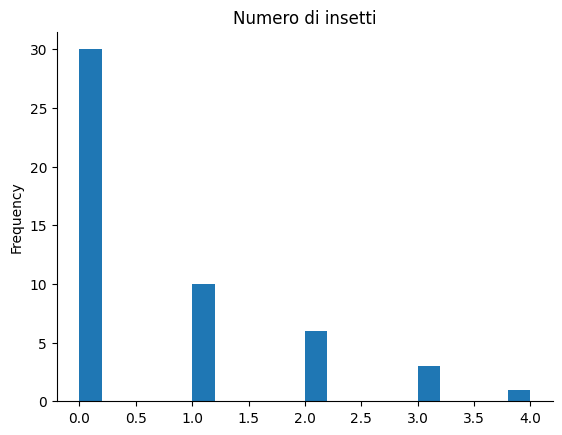

In [ ]:
# @title Numero di insetti

from matplotlib import pyplot as plt
merged_df['Numero di insetti'].plot(kind='hist', bins=20, title='Numero di insetti')
plt.gca().spines[['top', 'right',]].set_visible(False)

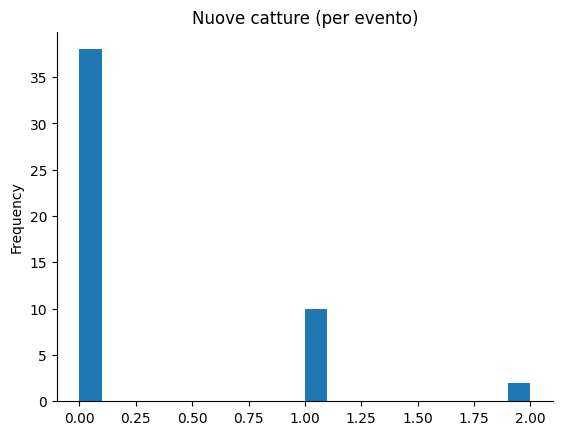

In [ ]:
# @title Nuove catture (per evento)

from matplotlib import pyplot as plt
merged_df['Nuove catture (per evento)'].plot(kind='hist', bins=20, title='Nuove catture (per evento)')
plt.gca().spines[['top', 'right',]].set_visible(False)

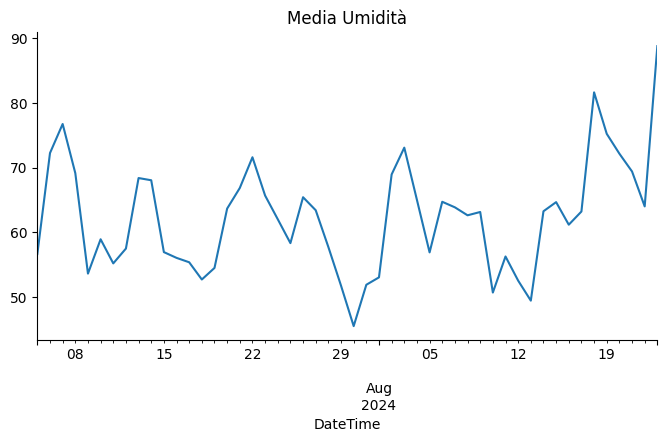

In [ ]:
# @title Media Umidità

from matplotlib import pyplot as plt
merged_df['Media Umidità'].plot(kind='line', figsize=(8, 4), title='Media Umidità')
plt.gca().spines[['top', 'right']].set_visible(False)

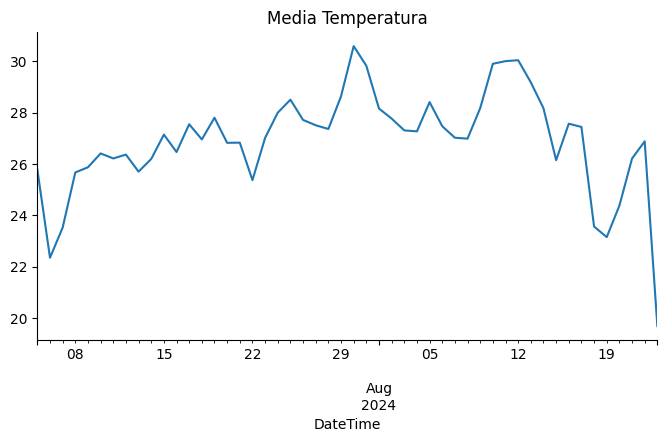

In [ ]:
# @title Media Temperatura

from matplotlib import pyplot as plt
merged_df['Media Temperatura'].plot(kind='line', figsize=(8, 4), title='Media Temperatura')
plt.gca().spines[['top', 'right']].set_visible(False)

Prima di applicare un modello di regressione, è necessario verificare se esistono relazioni tra le variabili. Di seguito, lo **Scatter Plot** ci mostra la distribuzione del **'Numero di Insetti'** e **'Nuove Catture (per evento)'** rispetto alla **Temperatura** e all'**Umidità**. Da questa analisi, possiamo osservare che, orientativamente, la maggior parte dei valori si concentrano tra i **26 e i 28 gradi** per la **Temperatura** e tra il **50 e il 70** per l'**Umidità**.

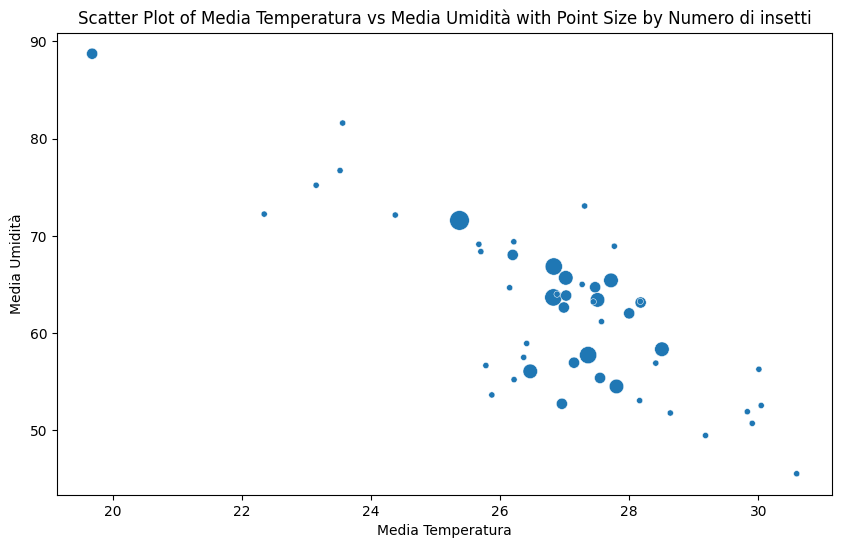

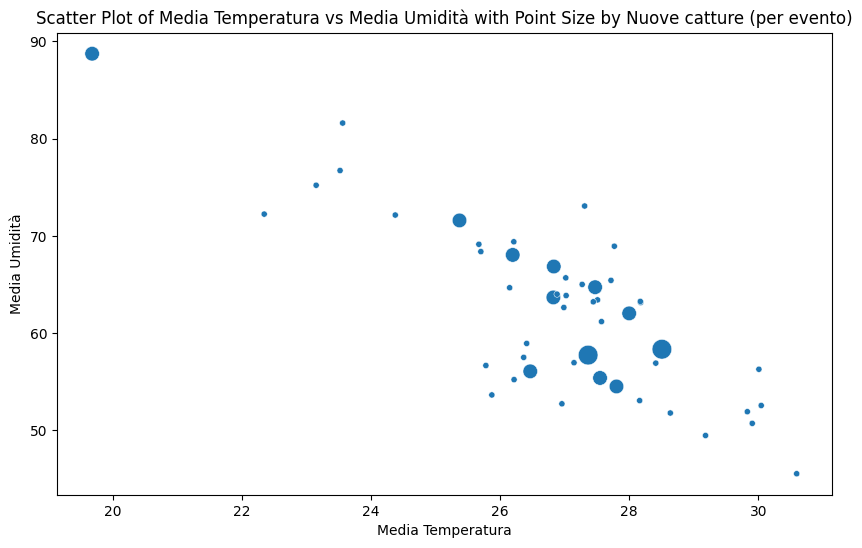

In [ ]:
def plot_scatter_with_size(df, x_col, y_col, size_col, figsize=(10, 6)):


    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x=x_col, y=y_col, size=size_col, legend=False, sizes=(20, 200))

    plt.title(f'Scatter Plot of {x_col} vs {y_col} with Point Size by {size_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.show()


plot_scatter_with_size(merged_df,	"Media Temperatura", 'Media Umidità', 'Numero di insetti')
plot_scatter_with_size(merged_df,	"Media Temperatura", 'Media Umidità', 'Nuove catture (per evento)')

# Analisi Quantitativa

La funzione *dataset_statistics* fornisce una serie di statistiche importanti per le decisioni successive. Restituisce la media di ogni colonna, i percentili (ad esempio, se x è il primo quartile, significa che il 25% dei dati è inferiore a x), *skewness* che indica se la distribuzione è asimmetrica e *kurtosis* che descrive la curvatura della distribuzione. La varianza misura la dispersione dei dati. Fondamentale è anche il test **Augmented Dickey-Fuller (ADF)**, che verifica se i dati sono stazionari.

In [ ]:
def dataset_statistics(df):

    numeric_df = df.select_dtypes(include=[np.number])
    stats = numeric_df.describe(percentiles=[.25, .5, .75]).T
    stats['Skewness'] = numeric_df.skew()
    stats['Kurtosis'] = numeric_df.kurtosis()
    stats['Variance'] = numeric_df.var()
    stats['IQR'] = stats['75%'] - stats['25%']


    adf_results = {}
    for column in numeric_df.columns:
        adf_test = adfuller(numeric_df[column].dropna())
        adf_results[column] = {
            'ADF Statistic': adf_test[0],
            'p-value': adf_test[1],
            'Critical Values': adf_test[4]
        }


    adf_df = pd.DataFrame(adf_results).T
    adf_df = adf_df[['ADF Statistic', 'p-value']]
    stats = pd.concat([stats, adf_df], axis=1)

    return stats

stats_df = dataset_statistics(merged_df)
stats_df

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis,Variance,IQR,ADF Statistic,p-value
Media Temperatura,50.0,26.900981,2.025520,19.675714,26.197969,27.082396,27.949219,30.594167,-1.098551,2.642206,4.102731,1.751250,-0.837516,0.807853
Media Umidità,50.0,62.405359,8.650729,45.544167,56.128021,63.189583,67.750208,88.742857,0.624642,0.655051,74.835120,11.622187,-3.029652,0.032217
Numero di insetti,50.0,0.700000,1.035098,0.000000,0.000000,0.000000,1.000000,4.000000,1.449138,1.367943,1.071429,1.000000,-2.52358,0.109842
Nuove catture (per evento),50.0,0.280000,0.536048,0.000000,0.000000,0.000000,0.000000,2.000000,1.804559,2.513532,0.287347,0.000000,-1.991534,0.290297


Per il *Numero di insetti*, possiamo osservare che la varianza è elevata, con una skewness di 1.45, che indica una distribuzione asimmetrica in cui la maggior parte dei valori è pari a 0 (infatti, il 50% dei dati è inferiore o uguale a 0). Il p-value di 0.11, essendo maggiore della soglia di 0.05, non permette di rifiutare l'ipotesi nulla, il che implica che la serie temporale non è stazionaria.

Lo stesso discorso può essere fatto per le *Nuove catture*: la varianza elevata, la skewness e il p-value maggiore di 0.05 suggeriscono che anche questa serie non è stazionaria.

# Analisi visuale dei dati



La funzione *max_correlation_matrix_with_type* calcola, per ogni coppia di variabili, i 3 tipi di correlazione: Pearson, Spearman e Kendall. Per ciascuna coppia, restituisce solo il tipo di correlazione con il valore più alto.

La funzione *calculate_vif* calcola il Variance Inflation Factor (**VIF**) per ogni colonna del DataFrame. Il **VIF** misura l'influenza della collinearità tra le variabili indipendenti in un modello di regressione. Valori elevati di VIF indicano che una variabile è fortemente correlata con le altre, suggerendo la possibilità di problemi di multicollinearità.

La funzione *create_grid_visualizations* genera una serie di grafici per esplorare i dati. In particolare:

Il Violin Plot mostra la distribuzione dei dati per ogni variabile numerica.
La HeatMap visualizza la matrice di correlazione massima tra tutte le coppie di variabili, con l'annotazione del tipo di correlazione (p = Pearson, s = Spearman, k = Kendall).
Un grafico a barre che rappresenta i valori di **VIF** per ogni colonna, con colorazione per evidenziare eventuali variabili con alti valori di **VIF**.
Un grafico CDF che mostra la distribuzione cumulativa delle probabilità per ogni variabile numerica.



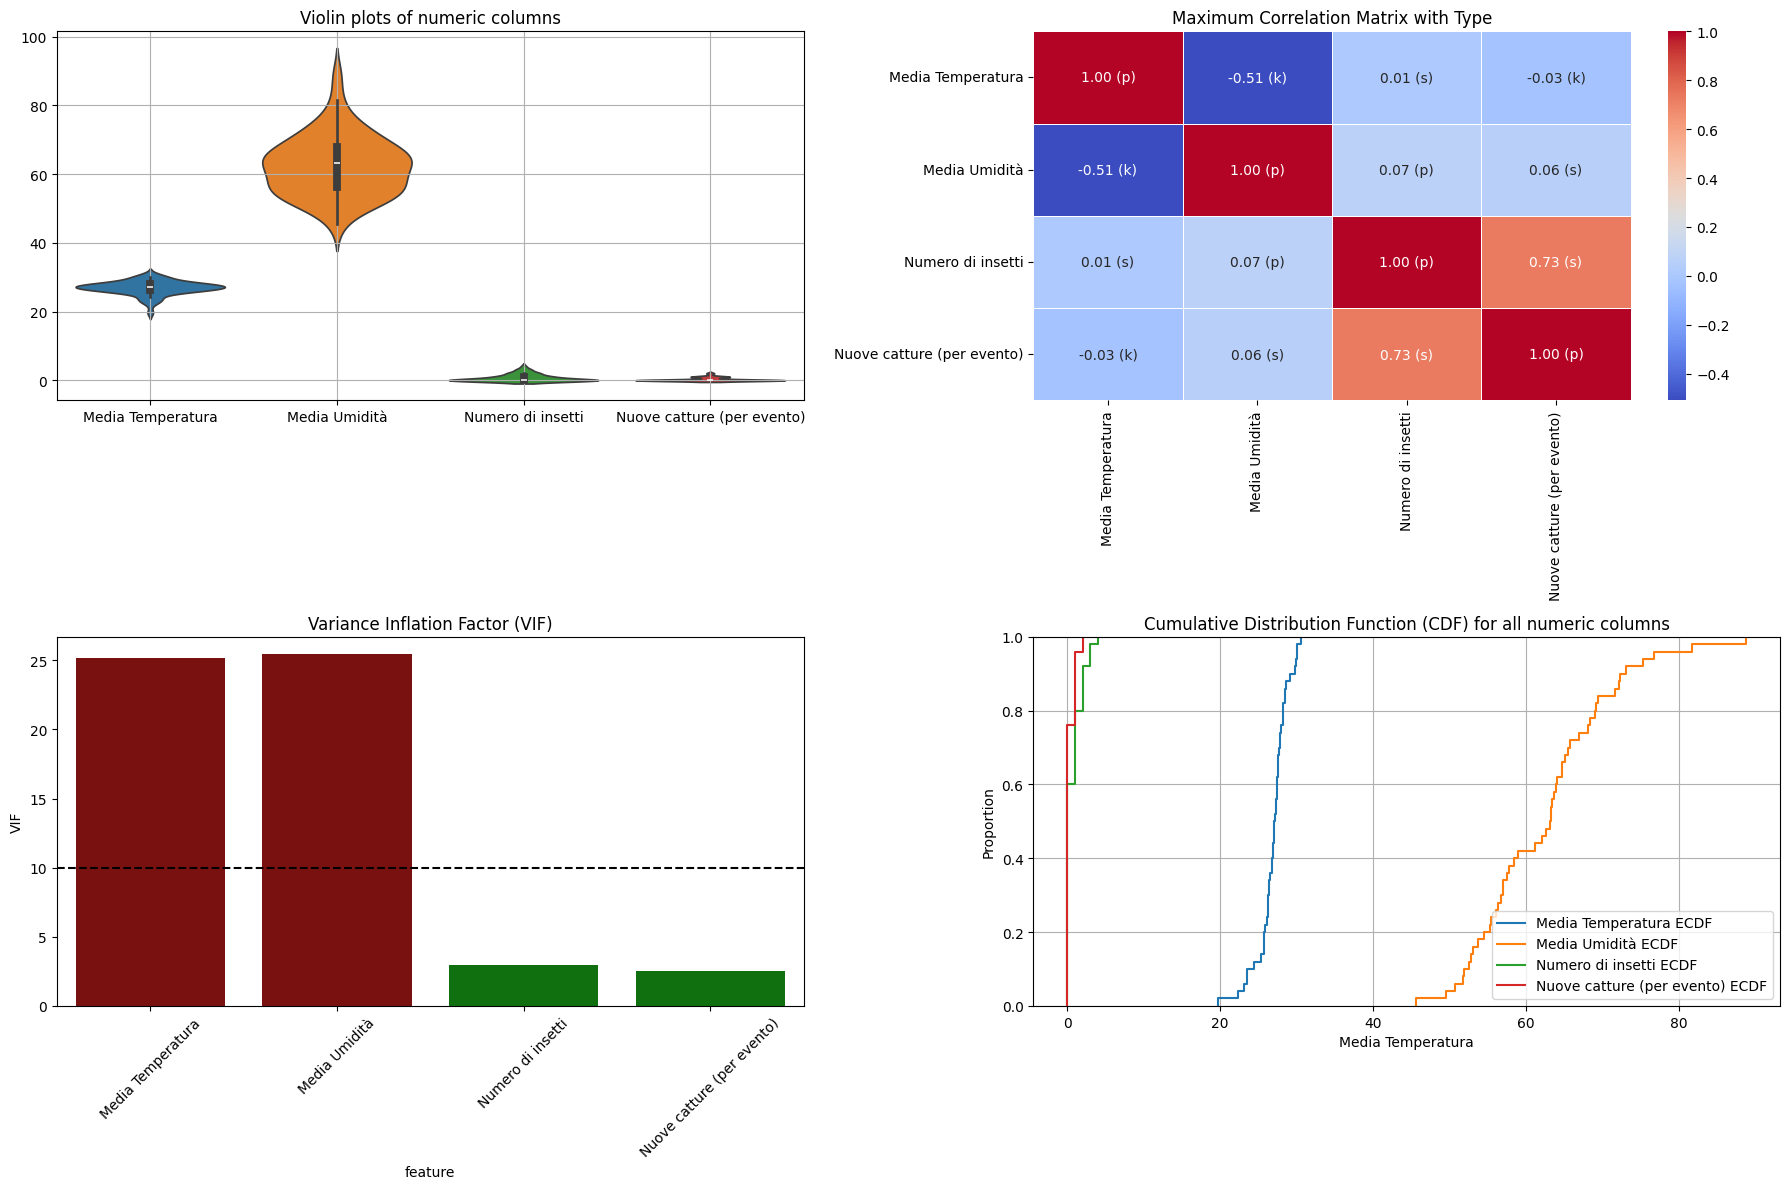

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def max_correlation_matrix_with_type(df):
    # Calculate different types of correlations
    pearson_corr = df.corr(method='pearson')  #il coefficiente di Pearson misura la linearità tra due variabili
    spearman_corr = df.corr(method='spearman') #la correlazione di Spearmina misura la monotonicità tra due variabili
    kendall_corr = df.corr(method='kendall') #la correlazione di Kendall simile a Spearman, ma basata su un metodo diverso di calcolo

    max_corr = pearson_corr.copy()  #max_corr è una matrice che contiene i valori di correlazione massima per ogni coppia di variabile
    corr_type = pd.DataFrame(index=pearson_corr.index, columns=pearson_corr.columns)

    for row in pearson_corr.index:
        for col in pearson_corr.columns:
            max_value = max(pearson_corr.at[row, col], spearman_corr.at[row, col], kendall_corr.at[row, col])
            max_corr.at[row, col] = max_value
            if max_value == pearson_corr.at[row, col]:
                corr_type.at[row, col] = 'p'
            elif max_value == spearman_corr.at[row, col]:
                corr_type.at[row, col] = 's'
            else:
                corr_type.at[row, col] = 'k'

    return max_corr, corr_type

def calculate_vif(df):  #calcolo del Variance Inflation Factor
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def create_grid_visualizations(df):
    numeric_df = df.select_dtypes(include=[np.number])

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    sns.violinplot(data=numeric_df, ax=axs[0, 0])
    axs[0, 0].set_title('Violin plots of numeric columns')
    axs[0, 0].grid(True)

    max_corr, corr_type = max_correlation_matrix_with_type(numeric_df)
    annot = np.array([['{:.2f} ({})'.format(max_corr.iloc[i, j], corr_type.iloc[i, j]) for j in range(len(max_corr.columns))] for i in range(len(max_corr))])
    sns.heatmap(max_corr, annot=annot, cmap='coolwarm', fmt='', linewidths=.5, ax=axs[0, 1])
    axs[0, 1].set_title('Maximum Correlation Matrix with Type')

    vif_data = calculate_vif(numeric_df)
    vif_colors = ['darkred' if x > 10 else 'red' if x > 5 else 'green' for x in vif_data['VIF']]
    bars = sns.barplot(x='feature', y='VIF', data=vif_data, palette=vif_colors, ax=axs[1, 0])
    axs[1, 0].axhline(10, color='black', linestyle='--')
    axs[1, 0].set_title('Variance Inflation Factor (VIF)')
    axs[1, 0].set_xticklabels(vif_data['feature'], rotation=45)
    for bar in bars.patches:
        if bar.get_width() > 10:
            bar.set_color('darkred')
        elif bar.get_width() > 5:
            bar.set_color('red')

    for column in numeric_df.columns:
        sns.ecdfplot(numeric_df[column], ax=axs[1, 1], label=f'{column} ECDF')
    axs[1, 1].set_title('Cumulative Distribution Function (CDF) for all numeric columns')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

create_grid_visualizations(merged_df)

Dal grafico dei **Violin Plots** possiamo osservare che le distribuzioni di *Numero di insetti* e *Nuove catture (per evento)* sono molto concentrate, soprattutto rispetto a quelle di *Media Temperatura* e *Media Umidità*, che presentano una maggiore variabilità.

Nella **matrice di correlazione** osserviamo le correlazioni massime calcolate in precedenza. Possiamo dire che *Media Temperatura* e *Media Umidità* sono fortemente anticorrelate secondo il coefficiente di Kendall, mentre *Numero di insetti* è positivamente correlato a *Nuove catture (per evento)*. Le altre correlazioni risultano deboli.

Il grafico del **VIF** mostra che *Media Temperatura* e *Media Umidità* presentano una forte multicollinearità. Le due variabili hanno un VIF alto, ma abbiamo ritenuto siano entrambe importanti per capire il fenomeno, ha senso tenerle nel modello, anche se i coefficienti potrebbero risultare meno stabili. Le altre variabili, invece, non evidenziano problemi di questo tipo.

Infine, il grafico della **CDF** ci mostra che *Numero di insetti* e *Nuove catture (per evento)* hanno distribuzioni concentrate vicino allo 0, mentre *Media Umidità* presenta una crescita graduale fino a circa 80.


# ACF E PACF PLOT

La funzione *advanced_time_series_analysis* analizza una serie temporale e fornisce informazioni utili per la selezione degli ordini degli algoritmi ARIMA. Gli input della funzione sono: il DataFrame contenente i dati, la colonna da analizzare, il parametro **lags** che indica il numero di ritardi da considerare per l'analisi di autocorrelazione e autocorrelazione parziale, e la **periodicità** dei dati.

**ACF (Autocorrelation Function)** mostra la correlazione tra i valori della serie temporale e i loro valori passati, considerando il numero specificato di ritardi. Questo grafico evidenzia come i valori della serie siano correlati con i ritardi, aiutando a comprendere la struttura temporale dei dati.

**PACF (Partial Autocorrelation Function)**, invece, mostra la correlazione diretta tra un valore della serie e i suoi ritardi, eliminando l'effetto delle correlazioni intermedie. Questo è utile per identificare il numero ottimale di ritardi da includere nel modello ARIMA.

Successivamente, viene eseguita la decomposizione della serie temporale per separare il **trend**, la **stagionalità** e il **residuo** (il rumore rimanente). Il trend rappresenta la componente a lungo termine, la stagionalità cattura i pattern ciclici regolari, mentre il residuo rappresenta le fluttuazioni casuali non spiegate dai modelli di trend e stagionalità.

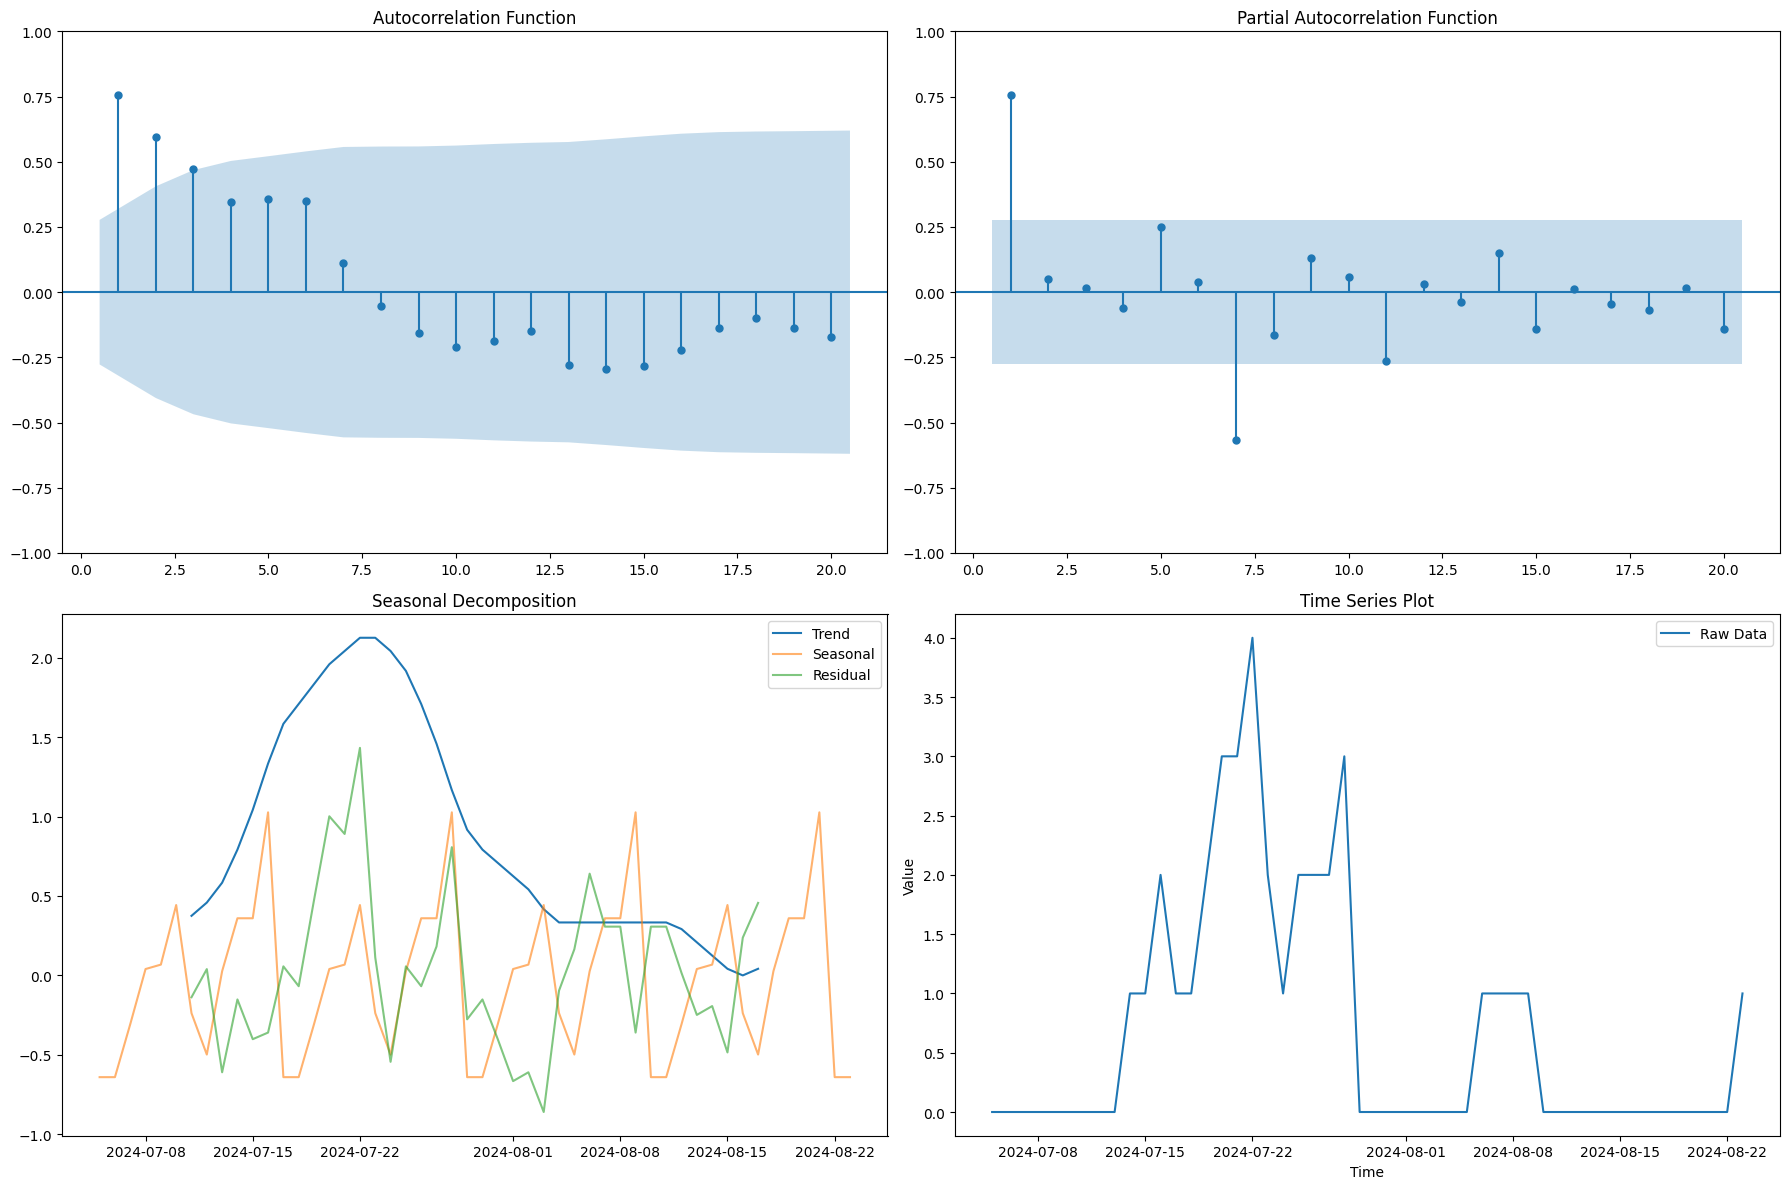

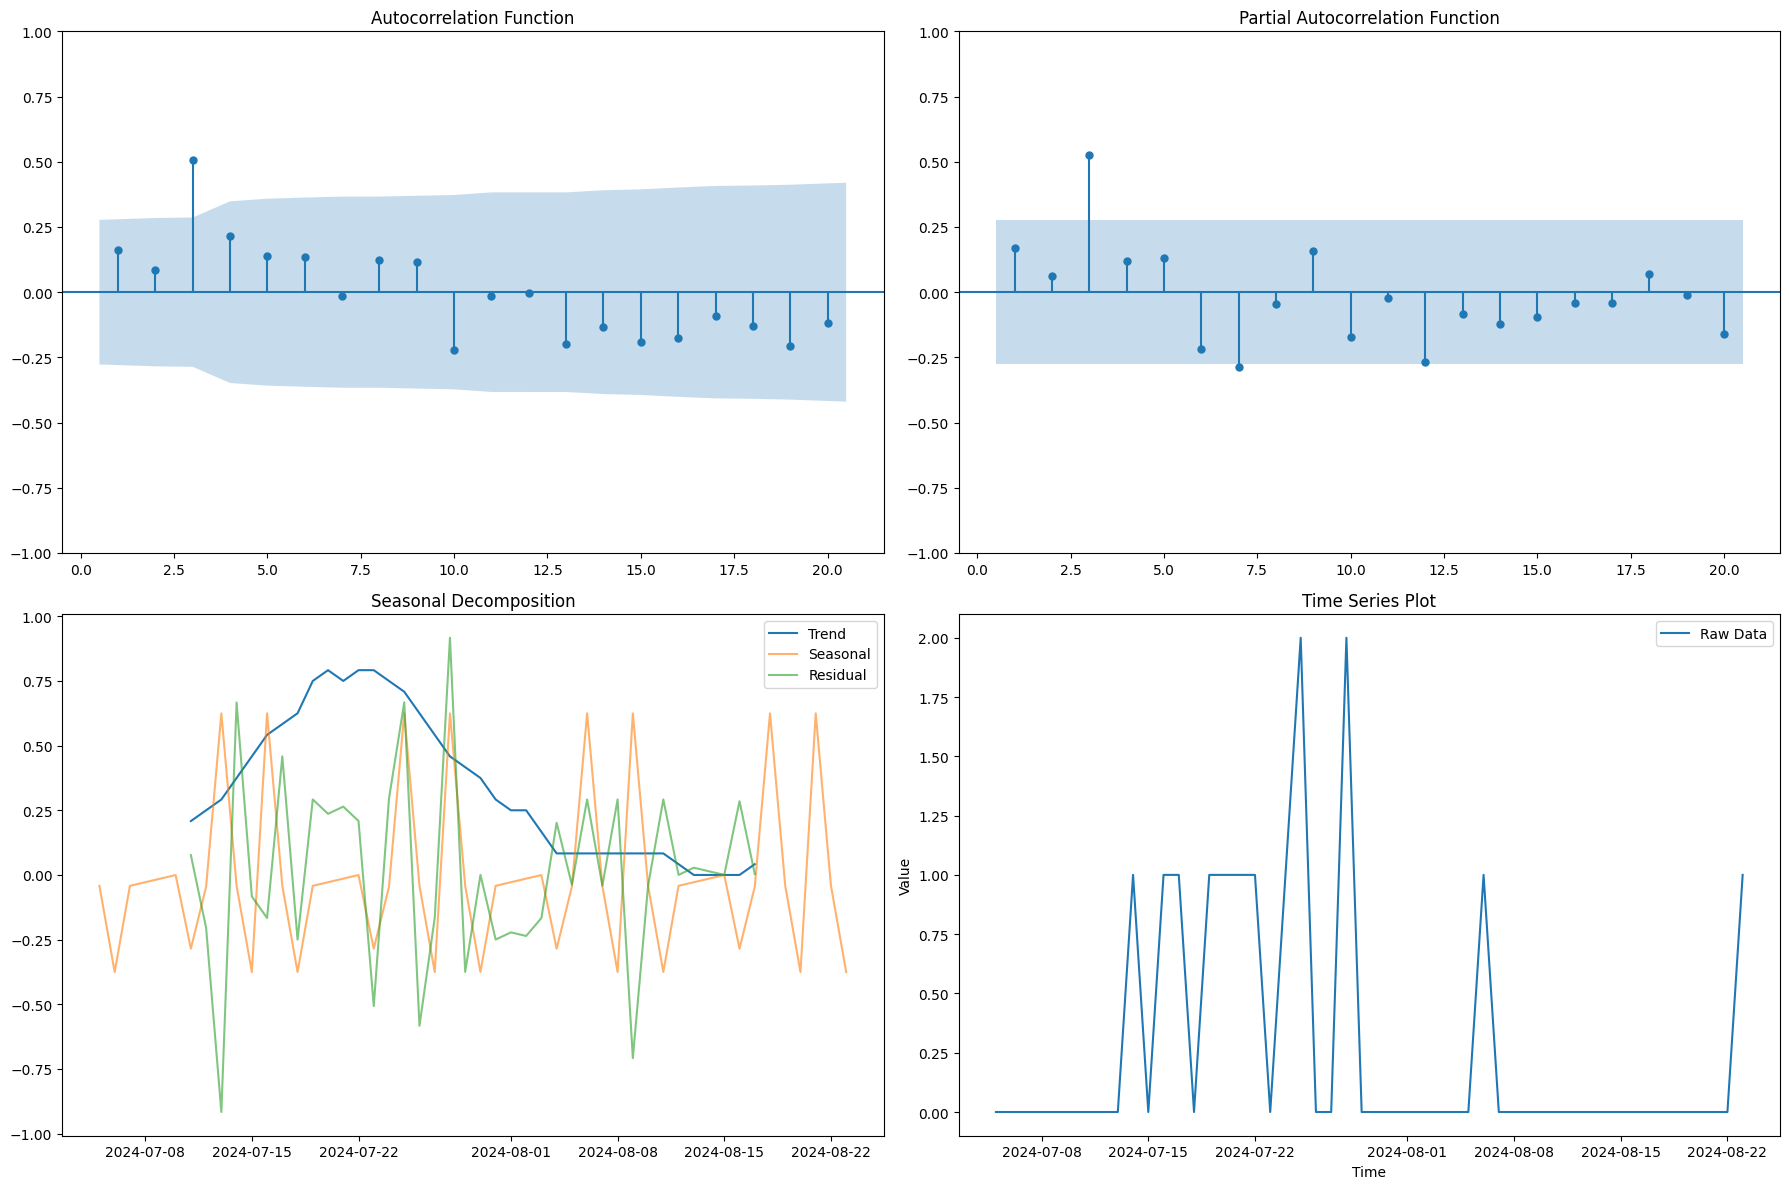

In [ ]:

def advanced_time_series_analysis(df, column, lags=40, period=None):
    time_series = df[column]

    if period is None:
        period = 12

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    plot_acf(time_series, ax=axs[0, 0], lags=lags, zero=False)
    axs[0, 0].set_title('Autocorrelation Function')

    plot_pacf(time_series, ax=axs[0, 1], lags=lags, zero=False, method='ols')
    axs[0, 1].set_title('Partial Autocorrelation Function')

    result = seasonal_decompose(time_series.dropna(), model='additive', period=period)
    axs[1, 0].plot(result.trend, label='Trend')
    axs[1, 0].plot(result.seasonal, label='Seasonal', alpha=0.6)
    axs[1, 0].plot(result.resid, label='Residual', alpha=0.6)
    axs[1, 0].legend()
    axs[1, 0].set_title('Seasonal Decomposition')

    axs[1, 1].plot(time_series.index, time_series, label='Raw Data')
    axs[1, 1].set_title('Time Series Plot')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


advanced_time_series_analysis(merged_df, 'Numero di insetti', lags=20, period=12)
advanced_time_series_analysis(merged_df, 'Nuove catture (per evento)', lags=20, period=12)

## **AGGIUNGRE DESCRIZIONE GRAFICO**

# AUTO-ARIMA

Il primo modello di regressione che utilizziamo è AUTO-ARIMA (AutoRegressive Integrated Moving Average). Esso si compone di tre componenti principali:

AR è la componente autoregressiva, ovvero la relazione tra la serie temporale e i suoi valori passati. Il parametro che definisce l'ordine di AR è p, cioè il numero di ritardi da considerare.

I è la componente di differenziazione, che serve a rendere la serie stazionaria. Il parametro che definisce l'ordine di differenziazione è d.

MA è la componente della media mobile, che rappresenta la relazione tra un valore della serie temporale e gli errori precedenti. Il parametro che definisce il numero di errori passati da considerare è q.

Il modello complessivo è rappresentato dalla notazione **ARIMA(p, d, q)**.

Auto-ARIMA è una versione automatizzata del modello ARIMA che ci permette di individuare automaticamente i valori ottimali per i parametri p, d e q.  Auto-ARIMA esplora una serie di possibili combinazioni per questi parametri e utilizza metodi statistici come l'AIC (Akaike Information Criterion) e il BIC (Bayesian Information Criterion) per determinarne i valori migliori per la serie temporale.


In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00


il **Numero di insetti** è la variabile target che voglio prevedere, mentre **Media Temperatura** e **Media Umidità** sono le variabili indipendenti, che influenzano la variabile dipendente. Il dataset viene diviso in due parti: l'80% dei dati viene utilizzato per l'addestramento del modello, mentre il restante 20% viene riservato per il testing.

Nel caso del *model_1*, stiamo addestrando un modello ARIMAX utilizzando sia le variabili dipendenti che quelle indipendenti, senza includere la componente di stagionalità nei dati. La funzione `auto_arima` esaminerà una gamma di valori per i parametri \(p\), \(d\) e \(q\), variando ciascuno tra 0 e 15, per identificare la combinazione ottimale che meglio si adatta ai dati.

*fitted_values_train* rappresenta i valori previsti dal modello per il set di addestramento. Questi valori sono elaborati per essere limitati inferiormente a 0 (evitando così valori negativi) e arrotondati all'intero più vicino.  

*forecast* contiene le previsioni del modello per un numero di periodi pari alla lunghezza del set di test. Contestualmente, gli intervalli di confidenza associati alle previsioni vengono restituiti in *conf_int*.

Successivamente, vengono calcolati, sia per il set di test che per il set di training:  

- **I residui**, ovvero la differenza tra i valori osservati e quelli previsti, che rappresentano gli errori di previsione del modello.  
- **Il Root Mean Squared Error (RMSE)**, ossia la radice quadrata della media degli errori quadratici, che misura la magnitudine media degli errori, dando maggior peso agli errori più grandi.  
- **Il Mean Absolute Error (MAE)**, cioè la media del valore assoluto dei residui, che indica l'entità media degli errori indipendentemente dal segno.  

Queste metriche permettono di valutare la qualità delle previsioni sia sul set di addestramento che su quello di test, confrontandole per individuare eventuali problemi di overfitting o underfitting e verificare l'accuratezza complessiva del modello.

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=141.189, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=117.079, Time=0.61 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=110.972, Time=1.24 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=3.18 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=96.463, Time=0.62 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=98.270, Time=1.61 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=94.974, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=96.567, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=98.379, Time=0.58 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=100.376, Time=0.85 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=95.242, Time=0.80 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=96.617, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=98.351, Time=3.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=100.356, Time=1.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=102.346, Time=2.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             :

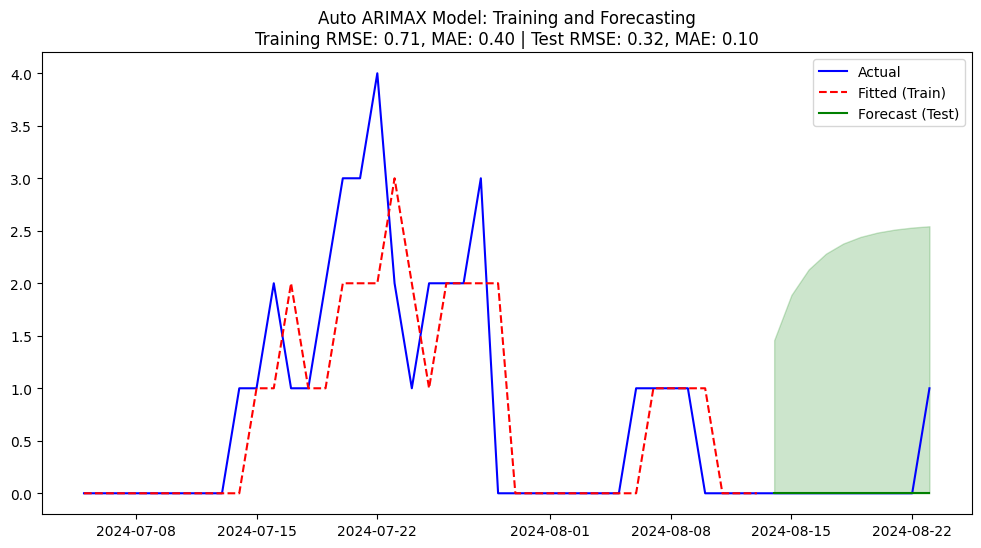

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

y = merged_df['Numero di insetti']  # Variabile dipendente
X = merged_df[['Media Temperatura', 'Media Umidità']]  # Variabili indipendente

train_size = int(len(merged_df) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

model_1 = pm.auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=False,
    start_p=0, max_p=15,
    start_q=0, max_q=15,
    max_d=5,
    stepwise=False,
    trace=True
)

fitted_values_train = model_1.predict_in_sample(exogenous=X_train).clip(lower=0).round()
forecast, conf_int = model_1.predict(n_periods=len(y_test), exogenous=X_test, return_conf_int=True)
forecasted_values_test = forecast.clip(lower=0).round()
confidence_intervals_test = np.clip(conf_int, 0, None)


residuals_train_arimax_1 = y_train - fitted_values_train
residuals_test_arimax_1 = y_test - forecasted_values_test


rmse_train_arima_1 = np.sqrt(mean_squared_error(y_train, fitted_values_train))
mae_train_arima_1 = mean_absolute_error(y_train, fitted_values_train)

rmse_test_arima_1 = np.sqrt(mean_squared_error(y_test, forecasted_values_test))
mae_test_arima_1 = mean_absolute_error(y_test, forecasted_values_test)


fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(y.index, y, label='Actual', color='blue')
ax.plot(fitted_values_train.index, fitted_values_train, color='red', linestyle='--', label='Fitted (Train)')
ax.plot(y_test.index, forecasted_values_test, label='Forecast (Test)', color='green')


ax.fill_between(
    y_test.index,
    confidence_intervals_test[:, 0],
    confidence_intervals_test[:, 1],
    color='green',
    alpha=0.2,
)


ax.set_title(f'Auto ARIMAX Model: Training and Forecasting\nTraining RMSE: {rmse_train_arima_1:.2f}, MAE: {mae_train_arima_1:.2f} | Test RMSE: {rmse_test_arima_1:.2f}, MAE: {mae_test_arima_1:.2f}')
ax.legend()

plt.show()


## **CONSIDERAZIONI SUL GRAFICO**
Il modello auto-ARIMA inizia testando diverse combinazioni di parametri \((p, d, q)\), partendo da \((0, 0, 0)\) fino a \((5, 0, 0)\) e confrontando i valori di **AIC**, che valuta il compromesso tra qualità dell'adattamento ai dati e complessità del modello, favorendo modelli semplici ed efficaci. La combinazione con il valore di **AIC** più basso, che rappresenta il miglior equilibrio tra semplicità e accuratezza, è \((1, 0, 0)\)  

Dall'immagine il set di training presenta un RMSE di 0,71 e un **MAE** di 0,40 mostrando che il modello si adatta bene ai dati di addestramento, come indicato dalla linea rossa (*Fitted Train*) che segue abbastanza da vicino i valori reali (*Actual*). Il set di test ha un **RMSE** di 0,32 e un **MAE** di 0,10, valori più bassi rispetto al training, il che suggerisce che il modello generalizza bene e produce previsioni accurate.

La funzione summary fornisce una panoramica completa del modello. In particolare, vengono riportate statistiche importanti come i valori di **AIC** e **BIC**, che aiutano a valutare la bontà dell'adattamento del modello e a confrontare diversi modelli. **Sigma2** rappresenta la varianza dell'errore, che misura la dispersione dei residui. I test diagnostici, come quello sull'eteroschedasticità, ci indicano se la varianza dei residui è costante nel tempo: un valore di 0.63 suggerisce che i residui sono omoschedastici, ovvero non mostrano variazioni significative nella loro dispersione. Inoltre, vengono riportati **skew** (asimmetria) e **kurtosis** (curtosi), che descrivono la forma della distribuzione dei residui. Un valore di skew negativo (-0.80) indica una leggera asimmetria verso sinistra, mentre un kurtosis pari a 5.81 suggerisce una distribuzione con code più pesanti rispetto alla distribuzione normale.

In [ ]:
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -45.487
Date:                Tue, 19 Nov 2024   AIC                             94.974
Time:                        19:34:21   BIC                             98.352
Sample:                    07-05-2024   HQIC                            96.195
                         - 08-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8235      0.052     15.861      0.000       0.722       0.925
sigma2         0.5533      0.094      5.863      0.000       0.368       0.738
Ljung-Box (L1) (Q):                   0.47   Jarque-

# **Estensione delle previsioni**

Nel codice sottostante, estendo la previsione oltre il dataset di addestramento per un periodo di 15 giorni. Per le variabili esogene, utilizzo il metodo *forward fill* per riempire i valori mancanti, assegnando ad essi i valori precedenti disponibili. Le previsioni future vengono generate utilizzando esclusivamente il modello addestrato in precedenza (*model_1*), senza modificare il modello durante l'estensione.

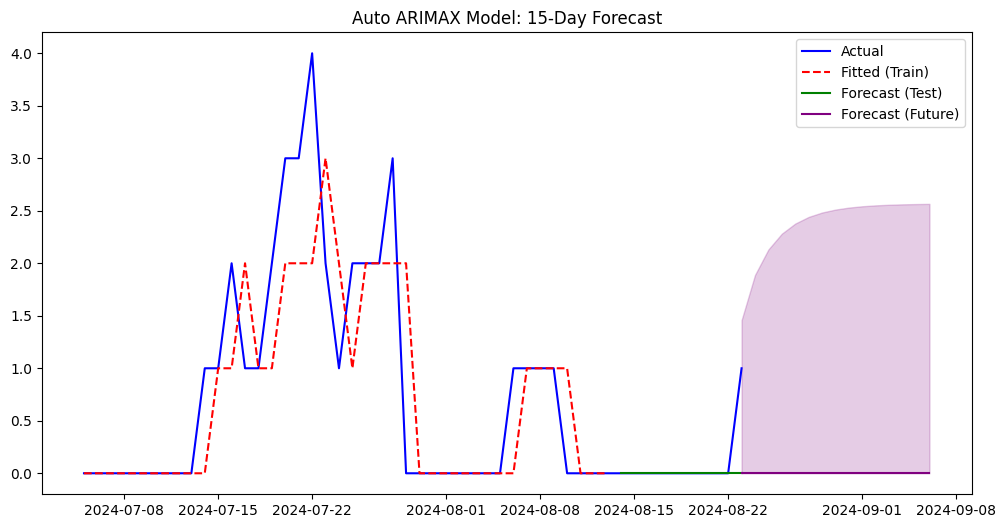

In [ ]:
future_dates = pd.date_range(start=merged_df.index[-1] + pd.Timedelta(days=0), periods=15)
future_X = pd.DataFrame(index=future_dates, columns=X.columns)

future_X = future_X.fillna(method='ffill')

forecast_future, conf_int_future = model_1.predict(n_periods=15, exogenous=future_X, return_conf_int=True)
forecasted_values_future = forecast_future.clip(lower=0).round()
confidence_intervals_future = np.clip(conf_int_future, 0, None)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y.index, y, label='Actual', color='blue')
ax.plot(fitted_values_train.index, fitted_values_train, color='red', linestyle='--', label='Fitted (Train)')
ax.plot(y_test.index, forecasted_values_test, label='Forecast (Test)', color='green')
ax.plot(future_dates, forecasted_values_future, label='Forecast (Future)', color='purple')
ax.fill_between(
    future_dates,
    confidence_intervals_future[:, 0],
    confidence_intervals_future[:, 1],
    color='purple',
    alpha=0.2,
)

ax.set_title(f'Auto ARIMAX Model: 15-Day Forecast')
ax.legend()
plt.show()


*testo in corsivo*### Riutilizzo del Modello Auto-ARIMA per Previsioni su una Nuova Variabile Target: *Nuove Catture (per Evento)*
Nel codice sottostante, riutilizzo il modello Auto-ARIMA per fare previsioni su una nuova variabile target, *Nuove Catture (per evento*). Per prima cosa, utilizzo Auto-ARIMA per identificare gli ordini ottimali del modello, che risultano essere (1, 0, 4). Successivamente, calcolo i residui e le statistiche di errore, come **RMSE** (Root Mean Squared Error) e **MAE** (Mean Absolute Error), per valutare la qualità del modello. Infine, utilizzo la funzione summary per ottenere una descrizione dettagliata del modello, e estendo la previsione fino a 15 giorni.

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=81.288, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=78.654, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=80.475, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=66.470, Time=0.41 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=66.778, Time=1.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=78.097, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=71.910, Time=0.53 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=69.542, Time=0.36 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=64.463, Time=0.57 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=64.018, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=78.639, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=73.017, Time=0.85 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=73.520, Time=5.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=66.044, Time=1.57 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6

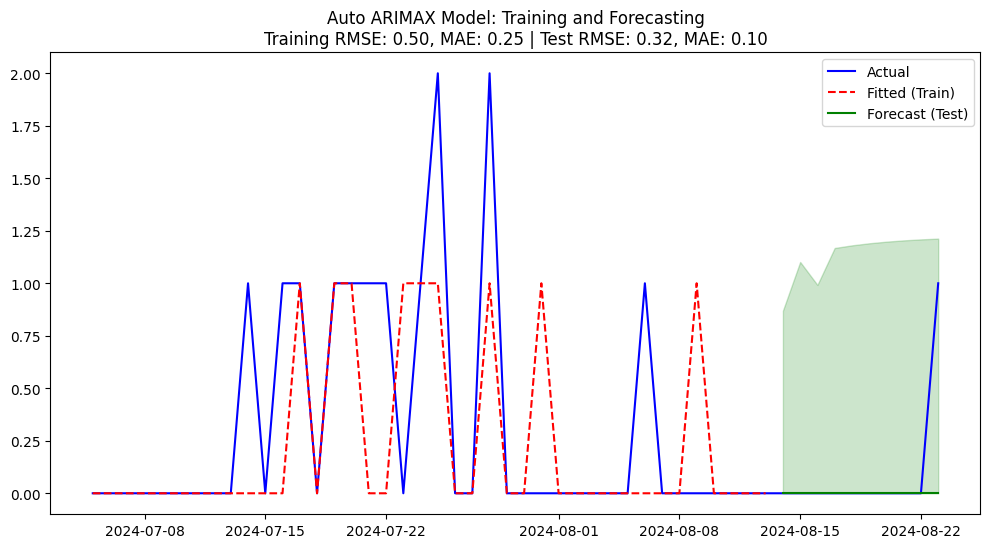

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

y = merged_df['Nuove catture (per evento)']
X = merged_df[['Media Temperatura', 'Media Umidità']]

train_size = int(len(merged_df) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

model_2 = pm.auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=False,
    start_p=0, max_p=15,
    start_q=0, max_q=15,
    max_d=5,
    stepwise=False,
    trace=True
)

fitted_values_train = model_2.predict_in_sample(exogenous=X_train).clip(lower=0).round()


forecast, conf_int = model_2.predict(n_periods=len(y_test), exogenous=X_test, return_conf_int=True)
forecasted_values_test = forecast.clip(lower=0).round()
confidence_intervals_test = np.clip(conf_int, 0, None)


residuals_train_arimax_2 = y_train - fitted_values_train
residuals_test_arimax_2 = y_test - forecasted_values_test


rmse_train_arima_2 = np.sqrt(mean_squared_error(y_train, fitted_values_train))
mae_train_arima_2 = mean_absolute_error(y_train, fitted_values_train)
# Test
rmse_test_arima_2 = np.sqrt(mean_squared_error(y_test, forecasted_values_test))
mae_test_arima_2 = mean_absolute_error(y_test, forecasted_values_test)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y.index, y, label='Actual', color='blue')
ax.plot(fitted_values_train.index, fitted_values_train, color='red', linestyle='--', label='Fitted (Train)')
ax.plot(y_test.index, forecasted_values_test, label='Forecast (Test)', color='green')


ax.fill_between(
    y_test.index,
    confidence_intervals_test[:, 0],
    confidence_intervals_test[:, 1],
    color='green',
    alpha=0.2,
)


ax.set_title(f'Auto ARIMAX Model: Training and Forecasting\nTraining RMSE: {rmse_train_arima_2:.2f}, MAE: {mae_train_arima_2:.2f} | Test RMSE: {rmse_test_arima_2:.2f}, MAE: {mae_test_arima_2:.2f}')
ax.legend()

plt.show()


In [ ]:
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:               SARIMAX(1, 0, 4)   Log Likelihood                 -26.009
Date:                Tue, 19 Nov 2024   AIC                             64.018
Time:                        19:34:40   BIC                             74.151
Sample:                    07-05-2024   HQIC                            67.682
                         - 08-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9148      0.117      7.792      0.000       0.685       1.145
ma.L1         -0.8901      0.272     -3.277      0.001      -1.422      -0.358
ma.L2          0.0551      0.296      0.186      0.8

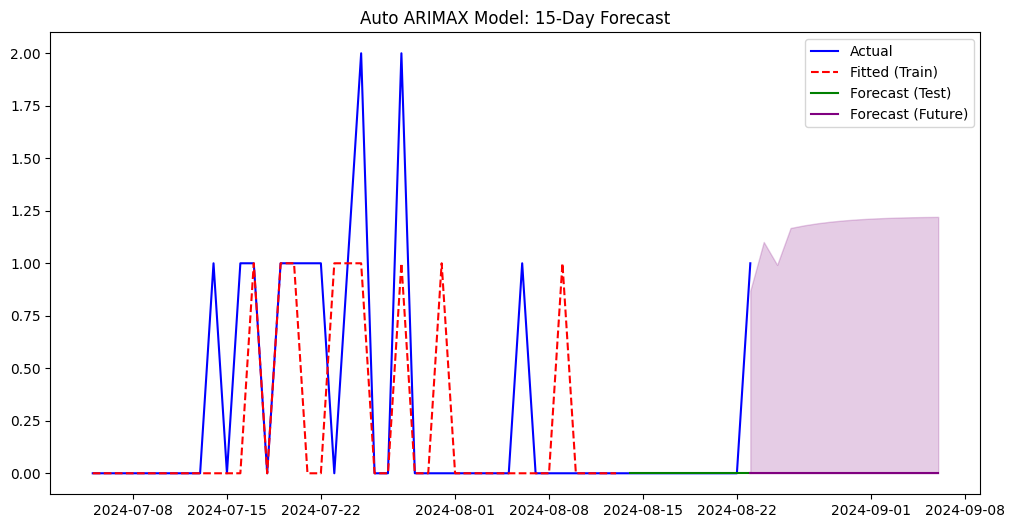

In [ ]:
future_dates = pd.date_range(start=merged_df.index[-1] + pd.Timedelta(days=0), periods=15)
future_X = pd.DataFrame(index=future_dates, columns=X.columns)

future_X = future_X.fillna(method='ffill')

forecast_future, conf_int_future = model_2.predict(n_periods=15, exogenous=future_X, return_conf_int=True)
forecasted_values_future = forecast_future.clip(lower=0).round()
confidence_intervals_future = np.clip(conf_int_future, 0, None)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y.index, y, label='Actual', color='blue')
ax.plot(fitted_values_train.index, fitted_values_train, color='red', linestyle='--', label='Fitted (Train)')
ax.plot(y_test.index, forecasted_values_test, label='Forecast (Test)', color='green')
ax.plot(future_dates, forecasted_values_future, label='Forecast (Future)', color='purple')
ax.fill_between(
    future_dates,
    confidence_intervals_future[:, 0],
    confidence_intervals_future[:, 1],
    color='purple',
    alpha=0.2,
)

ax.set_title(f'Auto ARIMAX Model: 15-Day Forecast')
ax.legend()
plt.show()

# VARIMAX

Il secondo modello regressivo che abbiamo utilizzato è il **VARMAX** (Vector Autoregressive Moving Average with Exogenous Variables), che è impiegato per fare previsioni su più variabili temporali contemporaneamente. In questo caso, la variabile target è "Numero di insetti", e il modello include anche altre variabili esogene.

Ricordiamo che le variabili endogene sono quelle variabili spiegate dal modello, il cui comportamento dipende da altre variabili all'interno dello stesso modello, mentre le variabili esogene, invece, sono fattori esterni che influenzano il modello, ma non sono spiegate dal modello stesso. Queste variabili possono affettare il comportamento delle variabili target (endogene), ma non sono influenzate dalle altre variabili del modello.

Le variabili esogene utilizzate nel modello sono:

*Media_Mobile_4gg*: la somma mobile dei valori della variabile target (Numero di insetti) su una finestra di 4 giorni.

*PCA_Componente*: una variabile derivante da un'analisi delle componenti principali (**PCA**), che combina *Media Temperatura, Media Umidità e Numero di insetti* in un'unica componente principale.

*Nuove catture (per evento)*: una variabile che rappresenta i nuovi eventi di cattura di insetti, che può influenzare il numero di insetti osservato.
Per costruire il modello, dividiamo le variabili in endogene ed esogene:

Le variabili endogene includono le serie temporali delle variabili target e altre variabili correlate, ossia Numero di insetti, Media Temperatura e Media Umidità.
Le variabili esogene sono *Nuove catture (per evento), Media_Mobile_4gg e PCA_Componente*, che vengono utilizzate come predittori esterni per il modello.
Il modello **VARMAX** viene addestrato utilizzando queste variabili per prevedere il Numero di insetti, tenendo conto sia delle dinamiche interne della serie temporale (endogene) che dei fattori esterni (esogeni).

In [ ]:
merged_df_copy = merged_df.copy()

merged_df_copy['Media_Mobile_4gg'] = merged_df_copy['Numero di insetti'].rolling(window=4).sum()

initial_mean = merged_df_copy['Numero di insetti'].iloc[:3].sum()  # Media dei primi 3 valori
merged_df_copy['Media_Mobile_4gg'].iloc[:3] = initial_mean



In [ ]:
features_for_pca = merged_df_copy[['Media Temperatura', 'Media Umidità', 'Numero di insetti']]


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_pca)

pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_features)

merged_df_copy['PCA_Component'] = pca_result

print(merged_df_copy.head())

            Media Temperatura  Media Umidità  Numero di insetti  \
DateTime                                                          
2024-07-05          25.777778      56.674444                0.0   
2024-07-06          22.342500      72.247500                0.0   
2024-07-07          23.517917      76.728750                0.0   
2024-07-08          25.669167      69.143750                0.0   
2024-07-09          25.870000      53.647083                0.0   

            Nuove catture (per evento)  Media_Mobile_4gg  PCA_Component  
DateTime                                                                 
2024-07-05                         0.0               0.0      -0.133474  
2024-07-06                         0.0               0.0       2.355880  
2024-07-07                         0.0               0.0       2.313096  
2024-07-08                         0.0               0.0       0.932927  
2024-07-09                         0.0               0.0      -0.415482  


Nel caso del modello **VARMAX**, l'ordine del modello è stato scelto tenendo conto di diversi fattori, a partire dall'ordine utilizzato nel modello precedente **ARIMAX**, e attraverso prove ripetute per identificare un buon equilibrio tra le performance del modello sui dati di training e test. In particolare, si è cercato di ottimizzare i valori di **RMSE**  e **MAE** per entrambe le fasi, con l'obiettivo di ottenere previsioni più accurate e robuste.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-package

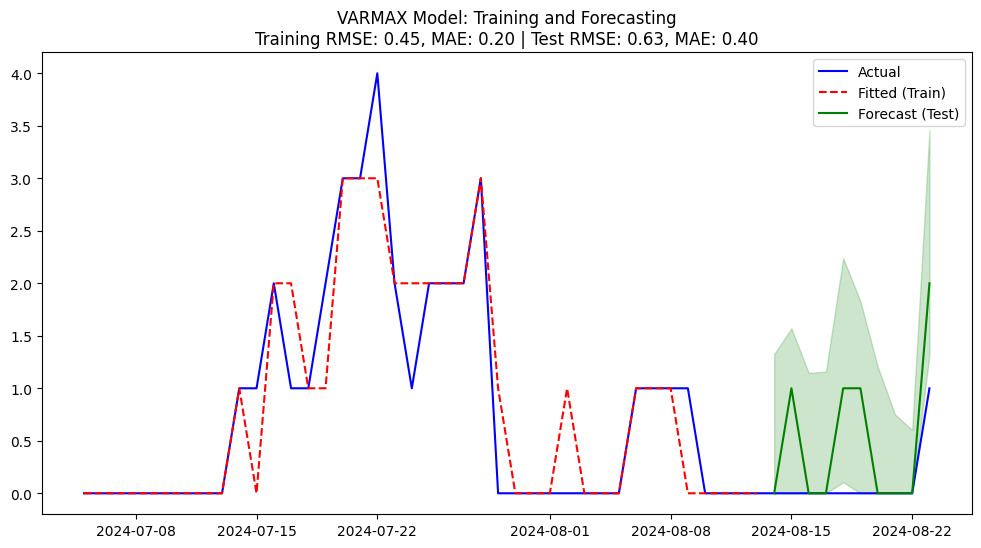

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error


endog = merged_df_copy[['Media Temperatura', 'Media Umidità', 'Numero di insetti']]
exog = merged_df_copy[['Media_Mobile_4gg', 'PCA_Component', 'Nuove catture (per evento)']]

train_size = int(len(merged_df_copy) * 0.8)
endog_train, endog_test = endog.iloc[:train_size], endog.iloc[train_size:]
exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

varmax_model_1 = sm.tsa.VARMAX(endog_train, exog=exog_train, order=(1, 1), trend='n').fit(disp=False)

fitted_values_train = varmax_model_1.fittedvalues.copy()
fitted_values_train['Numero di insetti'] = fitted_values_train['Numero di insetti'].clip(lower=0).round()

varmax_forecast = varmax_model_1.get_forecast(steps=len(endog_test), exog=exog_test)
forecasted_values_test = varmax_forecast.predicted_mean.copy()
forecasted_values_test['Numero di insetti'] = forecasted_values_test['Numero di insetti'].clip(lower=0).round()

confidence_intervals_test = varmax_forecast.conf_int()
confidence_intervals_test = confidence_intervals_test.clip(lower=0)

residuals_train_varmax_1 = endog_train['Numero di insetti'] - fitted_values_train['Numero di insetti']
residuals_test_varmax_1 = endog_test['Numero di insetti'] - forecasted_values_test['Numero di insetti']


rmse_train_varima_1 = np.sqrt(mean_squared_error(endog_train['Numero di insetti'], fitted_values_train['Numero di insetti']))
mae_train_varima_1 = mean_absolute_error(endog_train['Numero di insetti'], fitted_values_train['Numero di insetti'])


rmse_test_varima_1 = np.sqrt(mean_squared_error(endog_test['Numero di insetti'], forecasted_values_test['Numero di insetti']))
mae_test_varima_1 = mean_absolute_error(endog_test['Numero di insetti'], forecasted_values_test['Numero di insetti'])

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(endog.index, endog['Numero di insetti'], label='Actual', color='blue')
ax.plot(fitted_values_train.index, fitted_values_train['Numero di insetti'], color='red', linestyle='--', label='Fitted (Train)')
ax.plot(forecasted_values_test.index, forecasted_values_test['Numero di insetti'], label='Forecast (Test)', color='green')
ax.fill_between(confidence_intervals_test.index,
                confidence_intervals_test['lower Numero di insetti'],
                confidence_intervals_test['upper Numero di insetti'],
                color='green', alpha=0.2)

ax.set_title(f'VARMAX Model: Training and Forecasting\nTraining RMSE: {rmse_train_varima_1:.2f}, MAE: {mae_train_varima_1:.2f} | Test RMSE: {rmse_test_varima_1:.2f}, MAE: {mae_test_varima_1:.2f}')
ax.legend()

plt.show()


# VARMAX per *Nuove catture (per evento)*
Ripetiamo gli stessi procedimenti utilizzati precedentemente per la seconda variabile target, ovvero *Nuove catture (per evento)*, mantenendo le stesse variabili esogene, che sono *Media_Mobile_4gg, PCA_Component* (calcolato sulla nuova variabile) e *Numero di insetti*.

In [ ]:
merged_df_copy = merged_df.copy()

merged_df_copy['Media_Mobile_4gg'] = merged_df_copy['Nuove catture (per evento)'].rolling(window=4).sum()

initial_mean = merged_df_copy['Nuove catture (per evento)'].iloc[:3].sum()
merged_df_copy['Media_Mobile_4gg'].iloc[:3] = initial_mean

features_for_pca = merged_df_copy[['Media Temperatura', 'Media Umidità', 'Nuove catture (per evento)']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_pca)

pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_features)

merged_df_copy['PCA_Component'] = pca_result

print(merged_df_copy.head())

            Media Temperatura  Media Umidità  Numero di insetti  \
DateTime                                                          
2024-07-05          25.777778      56.674444                0.0   
2024-07-06          22.342500      72.247500                0.0   
2024-07-07          23.517917      76.728750                0.0   
2024-07-08          25.669167      69.143750                0.0   
2024-07-09          25.870000      53.647083                0.0   

            Nuove catture (per evento)  Media_Mobile_4gg  PCA_Component  
DateTime                                                                 
2024-07-05                         0.0               0.0       0.120930  
2024-07-06                         0.0               0.0      -2.367527  
2024-07-07                         0.0               0.0      -2.323022  
2024-07-08                         0.0               0.0      -0.942967  
2024-07-09                         0.0               0.0       0.402374  


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-package

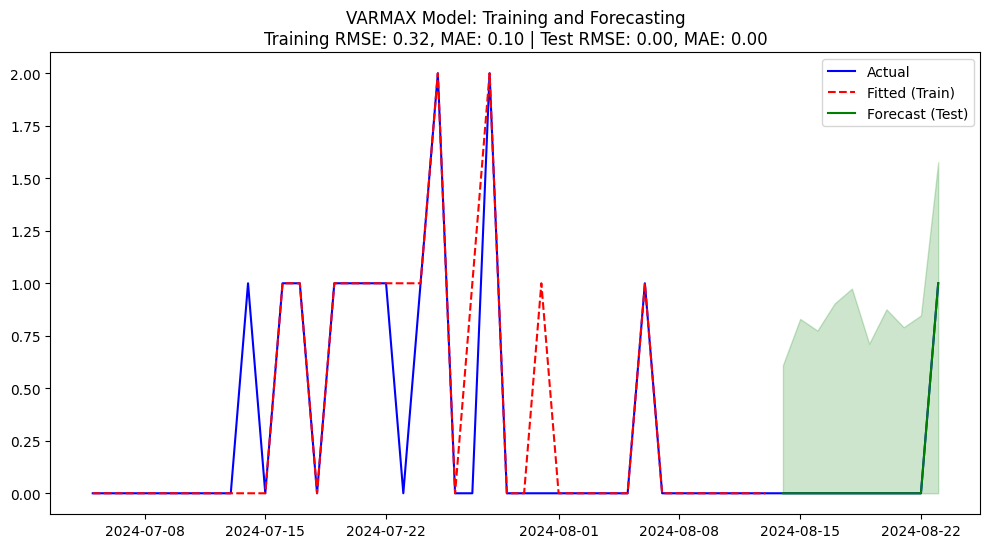

In [ ]:

endog = merged_df_copy[['Media Temperatura', 'Media Umidità', 'Nuove catture (per evento)']]
exog = merged_df_copy[['Media_Mobile_4gg', 'PCA_Component', 'Numero di insetti']]

train_size = int(len(merged_df_copy) * 0.8)
endog_train, endog_test = endog.iloc[:train_size], endog.iloc[train_size:]
exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

varmax_model_2 = sm.tsa.VARMAX(endog_train, exog=exog_train, order=(1, 1), trend='n').fit(disp=False) # SCEGLI L'ORDINE

fitted_values_train = varmax_model_2.fittedvalues.copy()
fitted_values_train['Nuove catture (per evento)'] = fitted_values_train['Nuove catture (per evento)'].clip(lower=0).round()

varmax_forecast = varmax_model_2.get_forecast(steps=len(endog_test), exog=exog_test)
forecasted_values_test = varmax_forecast.predicted_mean.copy()
forecasted_values_test['Nuove catture (per evento)'] = forecasted_values_test['Nuove catture (per evento)'].clip(lower=0).round()

confidence_intervals_test = varmax_forecast.conf_int()
confidence_intervals_test = confidence_intervals_test.clip(lower=0)  # Ensure non-negative bounds

residuals_train_varmax_2 = endog_train['Nuove catture (per evento)'] - fitted_values_train['Nuove catture (per evento)']
residuals_test_varmax_2 = endog_test['Nuove catture (per evento)'] - forecasted_values_test['Nuove catture (per evento)']

rmse_train_varima_2 = np.sqrt(mean_squared_error(endog_train['Nuove catture (per evento)'], fitted_values_train['Nuove catture (per evento)']))
mae_train_varima_2 = mean_absolute_error(endog_train['Nuove catture (per evento)'], fitted_values_train['Nuove catture (per evento)'])

rmse_test_varima_2 = np.sqrt(mean_squared_error(endog_test['Nuove catture (per evento)'], forecasted_values_test['Nuove catture (per evento)']))
mae_test_varima_2 = mean_absolute_error(endog_test['Nuove catture (per evento)'], forecasted_values_test['Nuove catture (per evento)'])

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(endog.index, endog['Nuove catture (per evento)'], label='Actual', color='blue')
ax.plot(fitted_values_train.index, fitted_values_train['Nuove catture (per evento)'], color='red', linestyle='--', label='Fitted (Train)')
ax.plot(forecasted_values_test.index, forecasted_values_test['Nuove catture (per evento)'], label='Forecast (Test)', color='green')
ax.fill_between(confidence_intervals_test.index,
                confidence_intervals_test['lower Nuove catture (per evento)'],
                confidence_intervals_test['upper Nuove catture (per evento)'],
                color='green', alpha=0.2)

ax.set_title(f'VARMAX Model: Training and Forecasting\nTraining RMSE: {rmse_train_varima_2:.2f}, MAE: {mae_train_varima_2:.2f} | Test RMSE: {rmse_test_varima_2:.2f}, MAE: {mae_test_varima_2:.2f}')
ax.legend()

plt.show()

# Confronto modello ARIMAX e VARMAX per *Numero di insetti*
Di seguito mostriamo un confronto grafico dei residui per le stesse previsioni, al fine di avere un'idea generale di quale modello abbia commesso meno errori.

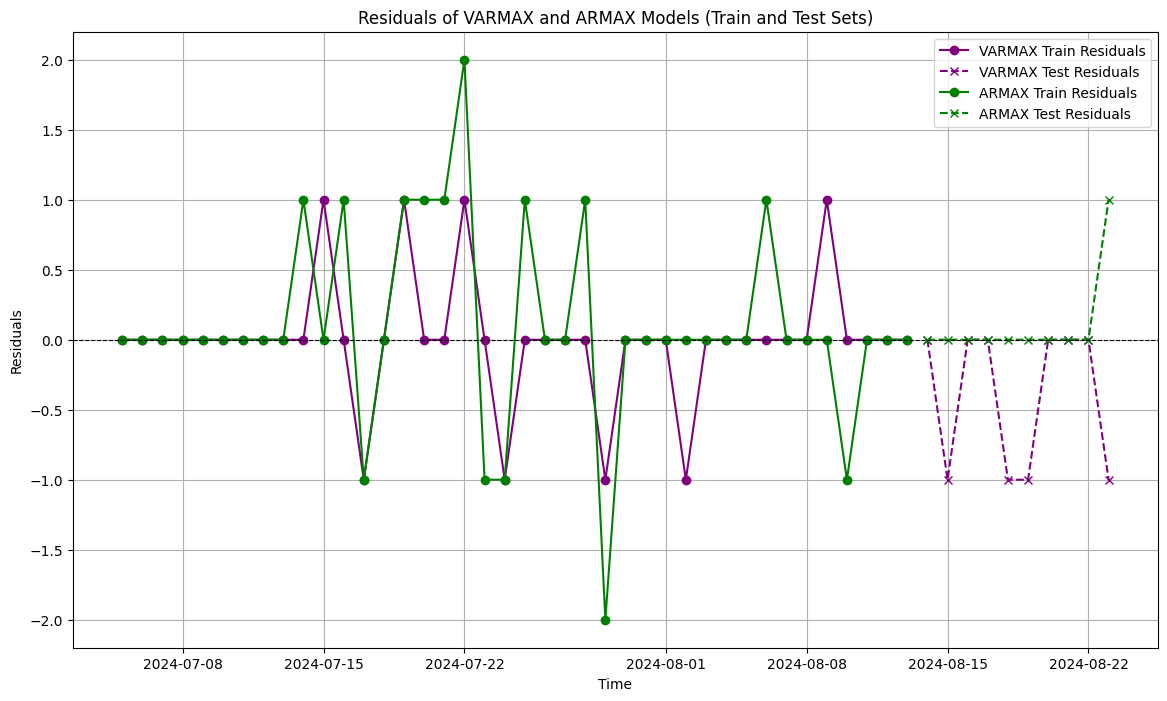

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))


plt.plot(residuals_train_varmax_1.index, residuals_train_varmax_1, color='purple', linestyle='-', marker='o', label='VARMAX Train Residuals')
plt.plot(residuals_test_varmax_1.index, residuals_test_varmax_1, color='purple', linestyle='--', marker='x', label='VARMAX Test Residuals')

plt.plot(residuals_train_arimax_1.index, residuals_train_arimax_1, color='green', linestyle='-', marker='o', label='ARMAX Train Residuals')
plt.plot(residuals_test_arimax_1.index, residuals_test_arimax_1, color='green', linestyle='--', marker='x', label='ARMAX Test Residuals')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.title('Residuals of VARMAX and ARMAX Models (Train and Test Sets)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

plt.show()

Nel codice sottostante, continuiamo il confronto tra i modelli **ARIMAX** e **VARMAX** con un'analisi più approfondita dei residui. Per entrambi i set di training e test, vengono creati grafici a barre che mostrano la somma dei residui assoluti e il conteggio dei residui positivi e negativi.

**La somma dei residui assoluti** aiuta a valutare quanto bene il modello si adatti ai dati: minori sono i residui assoluti, migliore è il modello.

**Il conteggio dei residui positivi e negativi**, d'altra parte, mostra se c'è un buon bilanciamento tra i due, un aspetto che indica la bontà del modello. Un buon modello dovrebbe avere un numero simile di residui positivi e negativi, mentre un modello che presenta una predominanza di uno dei due potrebbe suggerire un bias o un adattamento incompleto ai dati.

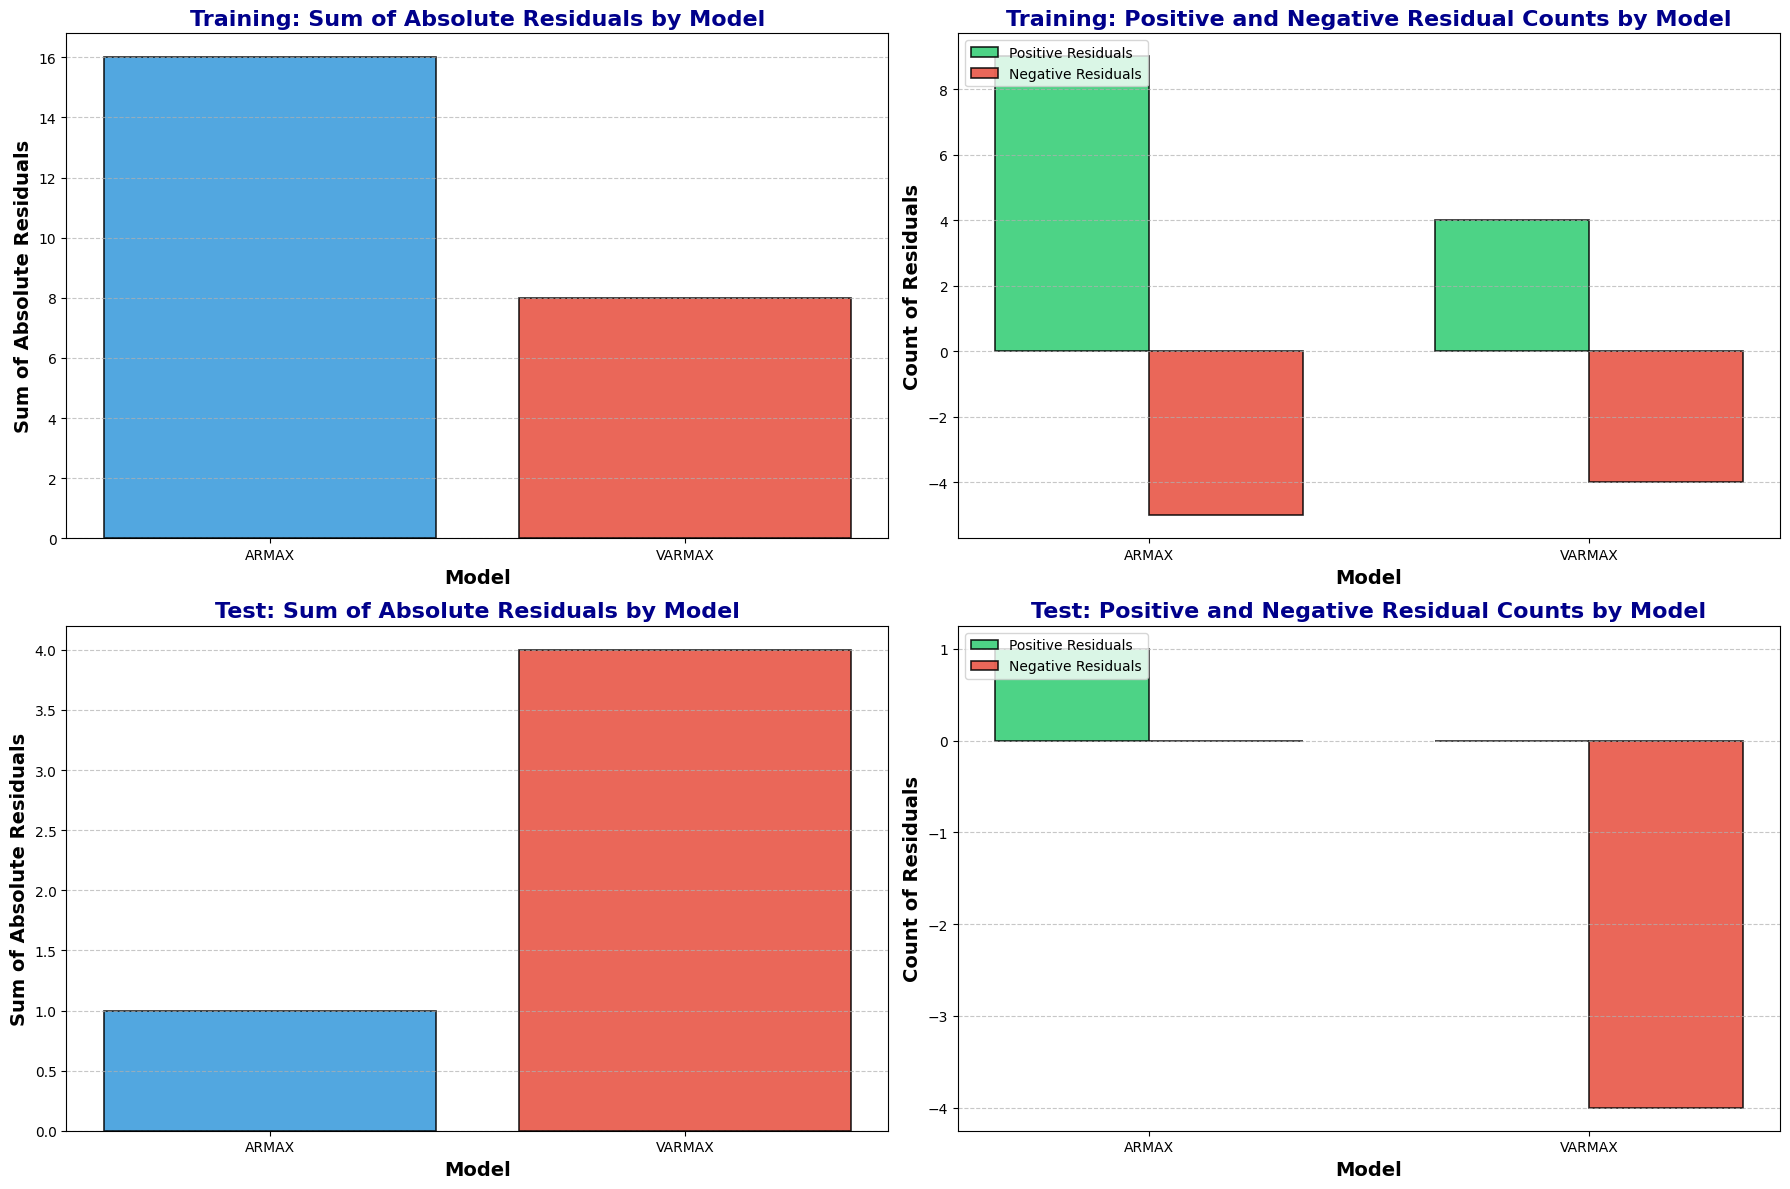

In [ ]:

abs_residuals_train_arimax_1 = np.abs(residuals_train_arimax_1)
abs_residuals_train_varmax_1 = np.abs(residuals_train_varmax_1)


abs_residuals_test_arimax_1 = np.abs(residuals_test_arimax_1)
abs_residuals_test_varmax_1 = np.abs(residuals_test_varmax_1)

total_abs_residuals_train_1 = [np.sum(abs_residuals_train_arimax_1), np.sum(abs_residuals_train_varmax_1)]
total_abs_residuals_test_1 = [np.sum(abs_residuals_test_arimax_1), np.sum(abs_residuals_test_varmax_1)]


count_positive_train_arimax_1 = np.sum(residuals_train_arimax_1 > 0)
count_negative_train_arimax_1 = np.sum(residuals_train_arimax_1 < 0)
count_positive_train_varmax_1 = np.sum(residuals_train_varmax_1 > 0)
count_negative_train_varmax_1 = np.sum(residuals_train_varmax_1 < 0)


count_positive_test_arimax_1 = np.sum(residuals_test_arimax_1 > 0)
count_negative_test_arimax_1 = np.sum(residuals_test_arimax_1 < 0)
count_positive_test_varmax_1 = np.sum(residuals_test_varmax_1 > 0)
count_negative_test_varmax_1 = np.sum(residuals_test_varmax_1 < 0)

positive_counts_train_1 = [count_positive_train_arimax_1, count_positive_train_varmax_1]
negative_counts_train_1 = [-count_negative_train_arimax_1, -count_negative_train_varmax_1]

positive_counts_test_1 = [count_positive_test_arimax_1, count_positive_test_varmax_1]
negative_counts_test_1 = [-count_negative_test_arimax_1, -count_negative_test_varmax_1]


fig, axs = plt.subplots(2, 2, figsize=(18, 12))

models = ['ARMAX', 'VARMAX']
colors = ['#3498db', '#e74c3c']
axs[0, 0].bar(models, total_abs_residuals_train_1, color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)
axs[0, 0].set_xlabel('Model', fontsize=14, fontweight='bold')
axs[0, 0].set_ylabel('Sum of Absolute Residuals', fontsize=14, fontweight='bold')
axs[0, 0].set_title('Training: Sum of Absolute Residuals by Model', fontsize=16, fontweight='bold', color='darkblue')
axs[0, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

index = np.arange(len(models))
bar_width = 0.35
axs[0, 1].bar(index - bar_width / 2, positive_counts_train_1, bar_width, label='Positive Residuals', color='#2ecc71', edgecolor='black', linewidth=1.2, alpha=0.85)
axs[0, 1].bar(index + bar_width / 2, negative_counts_train_1, bar_width, label='Negative Residuals', color='#e74c3c', edgecolor='black', linewidth=1.2, alpha=0.85)
axs[0, 1].set_xlabel('Model', fontsize=14, fontweight='bold')
axs[0, 1].set_ylabel('Count of Residuals', fontsize=14, fontweight='bold')
axs[0, 1].set_title('Training: Positive and Negative Residual Counts by Model', fontsize=16, fontweight='bold', color='darkblue')
axs[0, 1].set_xticks(index)
axs[0, 1].set_xticklabels(models)
axs[0, 1].legend(loc='upper left')
axs[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

axs[1, 0].bar(models, total_abs_residuals_test_1, color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)
axs[1, 0].set_xlabel('Model', fontsize=14, fontweight='bold')
axs[1, 0].set_ylabel('Sum of Absolute Residuals', fontsize=14, fontweight='bold')
axs[1, 0].set_title('Test: Sum of Absolute Residuals by Model', fontsize=16, fontweight='bold', color='darkblue')
axs[1, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

axs[1, 1].bar(index - bar_width / 2, positive_counts_test_1, bar_width, label='Positive Residuals', color='#2ecc71', edgecolor='black', linewidth=1.2, alpha=0.85)
axs[1, 1].bar(index + bar_width / 2, negative_counts_test_1, bar_width, label='Negative Residuals', color='#e74c3c', edgecolor='black', linewidth=1.2, alpha=0.85)
axs[1, 1].set_xlabel('Model', fontsize=14, fontweight='bold')
axs[1, 1].set_ylabel('Count of Residuals', fontsize=14, fontweight='bold')
axs[1, 1].set_title('Test: Positive and Negative Residual Counts by Model', fontsize=16, fontweight='bold', color='darkblue')
axs[1, 1].set_xticks(index)
axs[1, 1].set_xticklabels(models)
axs[1, 1].legend(loc='upper left')
axs[1, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Confronto modello ARIMAX e VARMAX per *Nuove catture (per evento)*


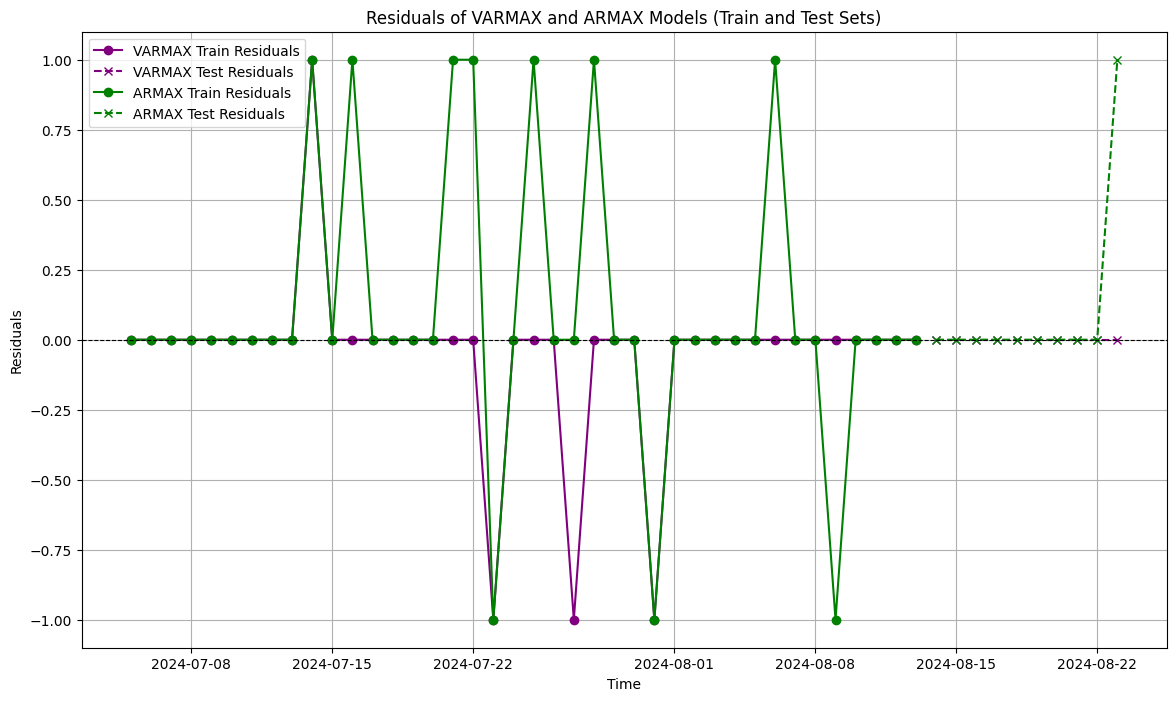

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

plt.plot(residuals_train_varmax_2.index, residuals_train_varmax_2, color='purple', linestyle='-', marker='o', label='VARMAX Train Residuals')
plt.plot(residuals_test_varmax_2.index, residuals_test_varmax_2, color='purple', linestyle='--', marker='x', label='VARMAX Test Residuals')

plt.plot(residuals_train_arimax_2.index, residuals_train_arimax_2, color='green', linestyle='-', marker='o', label='ARMAX Train Residuals')
plt.plot(residuals_test_arimax_2.index, residuals_test_arimax_2, color='green', linestyle='--', marker='x', label='ARMAX Test Residuals')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.title('Residuals of VARMAX and ARMAX Models (Train and Test Sets)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

plt.show()

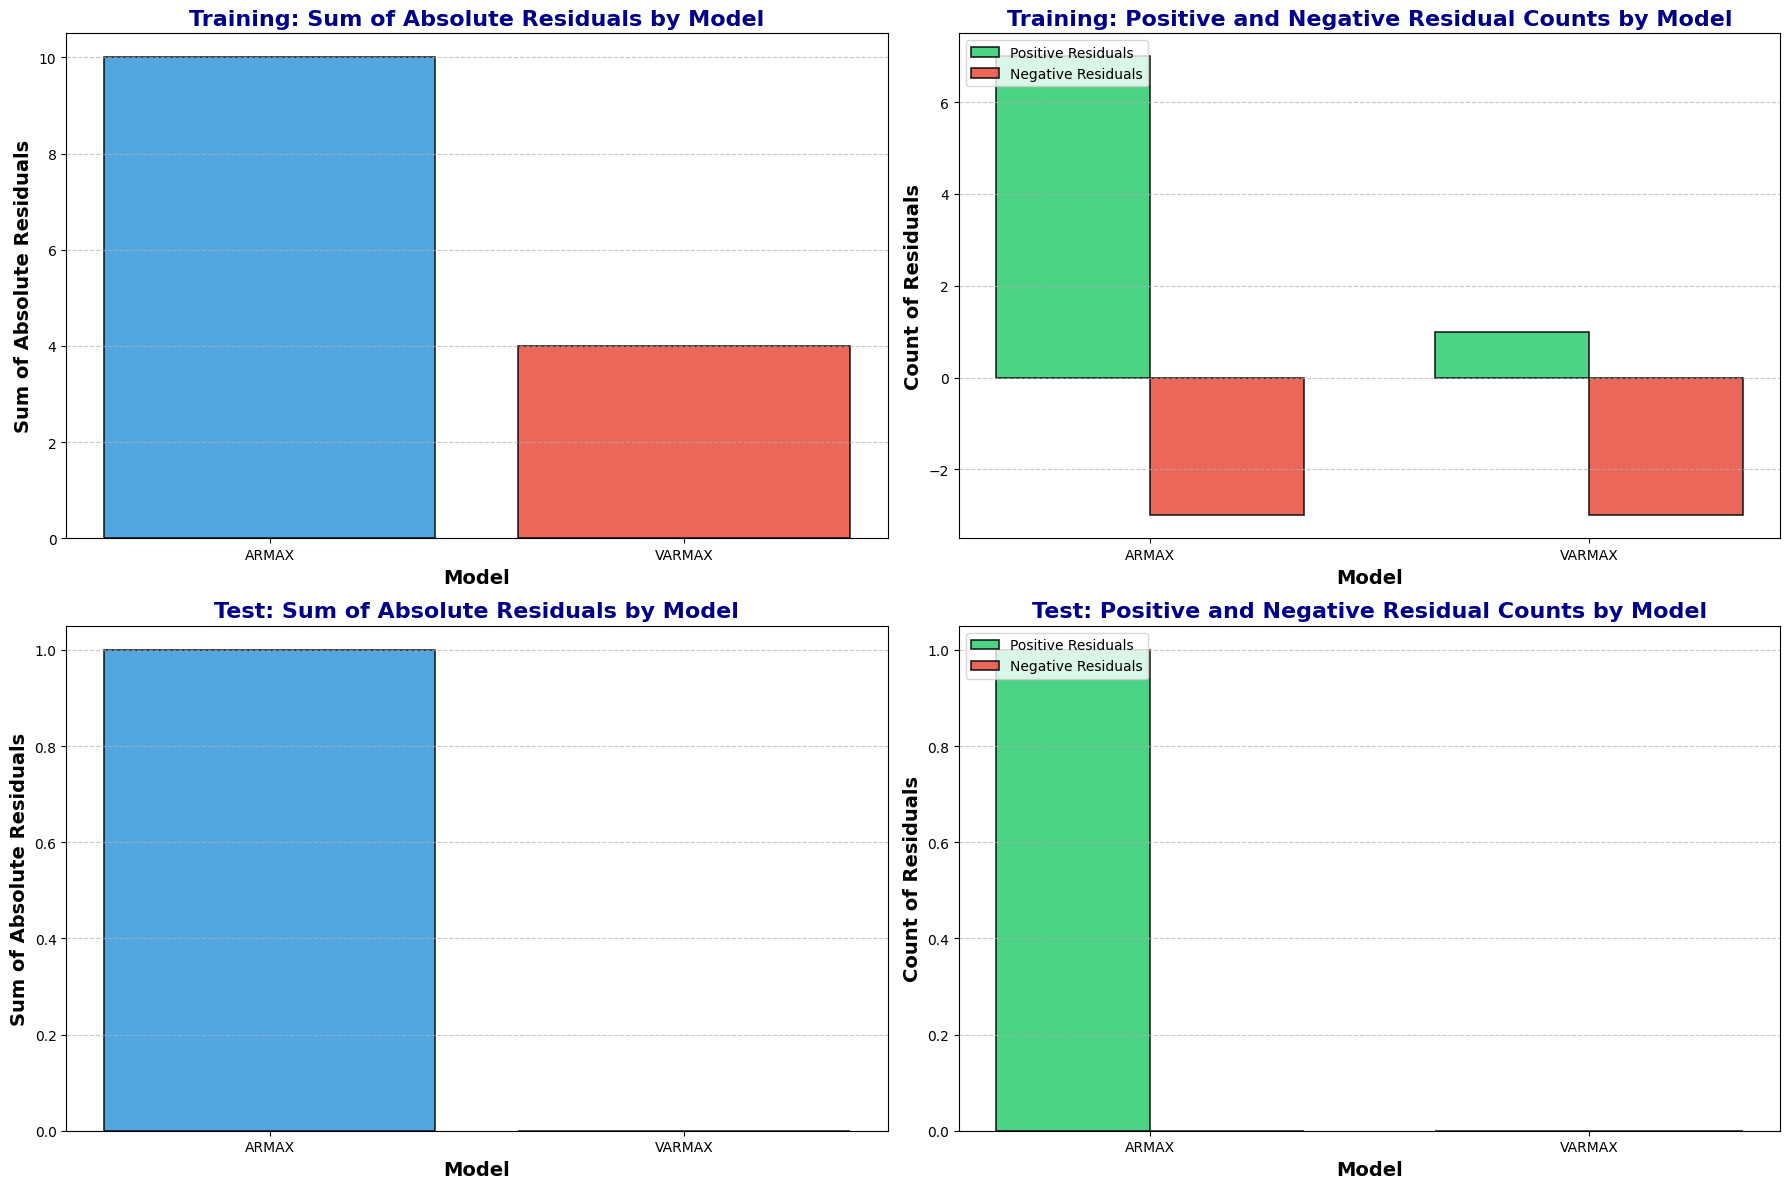

In [ ]:
abs_residuals_train_arimax_2 = np.abs(residuals_train_arimax_2)
abs_residuals_train_varmax_2 = np.abs(residuals_train_varmax_2)

abs_residuals_test_arimax_2 = np.abs(residuals_test_arimax_2)
abs_residuals_test_varmax_2 = np.abs(residuals_test_varmax_2)

total_abs_residuals_train_2 = [np.sum(abs_residuals_train_arimax_2), np.sum(abs_residuals_train_varmax_2)]
total_abs_residuals_test_2 = [np.sum(abs_residuals_test_arimax_2), np.sum(abs_residuals_test_varmax_2)]

count_positive_train_arimax_2 = np.sum(residuals_train_arimax_2 > 0)
count_negative_train_arimax_2 = np.sum(residuals_train_arimax_2 < 0)
count_positive_train_varmax_2 = np.sum(residuals_train_varmax_2 > 0)
count_negative_train_varmax_2 = np.sum(residuals_train_varmax_2 < 0)

count_positive_test_arimax_2 = np.sum(residuals_test_arimax_2 > 0)
count_negative_test_arimax_2 = np.sum(residuals_test_arimax_2 < 0)
count_positive_test_varmax_2 = np.sum(residuals_test_varmax_2 > 0)
count_negative_test_varmax_2 = np.sum(residuals_test_varmax_2 < 0)

positive_counts_train_2 = [count_positive_train_arimax_2, count_positive_train_varmax_2]
negative_counts_train_2 = [-count_negative_train_arimax_2, -count_negative_train_varmax_2]  # Negative for visual effect

positive_counts_test_2 = [count_positive_test_arimax_2, count_positive_test_varmax_2]
negative_counts_test_2 = [-count_negative_test_arimax_2, -count_negative_test_varmax_2]  # Negative for visual effect


fig, axs = plt.subplots(2, 2, figsize=(18, 12))

models = ['ARMAX', 'VARMAX']
colors = ['#3498db', '#e74c3c']
axs[0, 0].bar(models, total_abs_residuals_train_2, color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)
axs[0, 0].set_xlabel('Model', fontsize=14, fontweight='bold')
axs[0, 0].set_ylabel('Sum of Absolute Residuals', fontsize=14, fontweight='bold')
axs[0, 0].set_title('Training: Sum of Absolute Residuals by Model', fontsize=16, fontweight='bold', color='darkblue')
axs[0, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

index = np.arange(len(models))
bar_width = 0.35
axs[0, 1].bar(index - bar_width / 2, positive_counts_train_2, bar_width, label='Positive Residuals', color='#2ecc71', edgecolor='black', linewidth=1.2, alpha=0.85)
axs[0, 1].bar(index + bar_width / 2, negative_counts_train_2, bar_width, label='Negative Residuals', color='#e74c3c', edgecolor='black', linewidth=1.2, alpha=0.85)
axs[0, 1].set_xlabel('Model', fontsize=14, fontweight='bold')
axs[0, 1].set_ylabel('Count of Residuals', fontsize=14, fontweight='bold')
axs[0, 1].set_title('Training: Positive and Negative Residual Counts by Model', fontsize=16, fontweight='bold', color='darkblue')
axs[0, 1].set_xticks(index)
axs[0, 1].set_xticklabels(models)
axs[0, 1].legend(loc='upper left')
axs[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

axs[1, 0].bar(models, total_abs_residuals_test_2, color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)
axs[1, 0].set_xlabel('Model', fontsize=14, fontweight='bold')
axs[1, 0].set_ylabel('Sum of Absolute Residuals', fontsize=14, fontweight='bold')
axs[1, 0].set_title('Test: Sum of Absolute Residuals by Model', fontsize=16, fontweight='bold', color='darkblue')
axs[1, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

axs[1, 1].bar(index - bar_width / 2, positive_counts_test_2, bar_width, label='Positive Residuals', color='#2ecc71', edgecolor='black', linewidth=1.2, alpha=0.85)
axs[1, 1].bar(index + bar_width / 2, negative_counts_test_2, bar_width, label='Negative Residuals', color='#e74c3c', edgecolor='black', linewidth=1.2, alpha=0.85)
axs[1, 1].set_xlabel('Model', fontsize=14, fontweight='bold')
axs[1, 1].set_ylabel('Count of Residuals', fontsize=14, fontweight='bold')
axs[1, 1].set_title('Test: Positive and Negative Residual Counts by Model', fontsize=16, fontweight='bold', color='darkblue')
axs[1, 1].set_xticks(index)
axs[1, 1].set_xticklabels(models)
axs[1, 1].legend(loc='upper left')
axs[1, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Ensemble Learning : Numero di insetti

L'ensemble non è un singolo modello, ma una combinazione di diversi modelli di previsione. Il suo obiettivo è migliorare le performance generali combinando i punti di forza di ciascun modello, riducendo al contempo gli errori individuali. Questo approccio è particolarmente utile quando i singoli modelli sono soggetti a overfitting o underfitting, in quanto consente di ottenere previsioni più robuste e accurate.

In particolare, abbiamo applicato due algoritmi di regressione:

**Gradient Boosting Regression (GBM)**, che costruisce iterativamente alberi decisionali, correggendo gli errori residuali dei modelli precedenti e migliorando le previsioni complessive. Questo approccio ottimizza progressivamente la previsione, dando maggiore peso agli errori più difficili da correggere.

**Random Forest Regressor**, che crea una foresta di alberi decisionali, ciascuno dei quali fornisce una previsione. La previsione finale è data dalla media delle previsioni degli alberi individuali, riducendo così la varianza e migliorando la stabilità e la robustezza del modello.

Il numero di **estimatori** è impostato a 100, il che significa che il modello utilizza 100 alberi decisionali. Un numero maggiore di alberi può aumentare la precisione, ma rischia anche di causare overfitting. Il **learning rate** è 0.1, il che indica che ogni albero contribuisce in modo moderato al miglioramento delle previsioni, evitando aggiornamenti troppo rapidi. La profondità massima dell'albero (*max_depth* = 3) è impostata a 3 per limitare la complessità degli alberi decisionali e prevenire l'overfitting, mantenendo il modello semplice e generalizzabile.

La funzione *create_lagged_features* aggiunge al DataFrame tre variabili lagged fino a 3 lags, oltre alle variabili esogene (*Media Temperatura e Media Umidità*) e alla variabile target (*Numero di insetti*). L'aggiunta delle variabili lagged serve a catturare le dipendenze temporali e migliorare le previsioni.

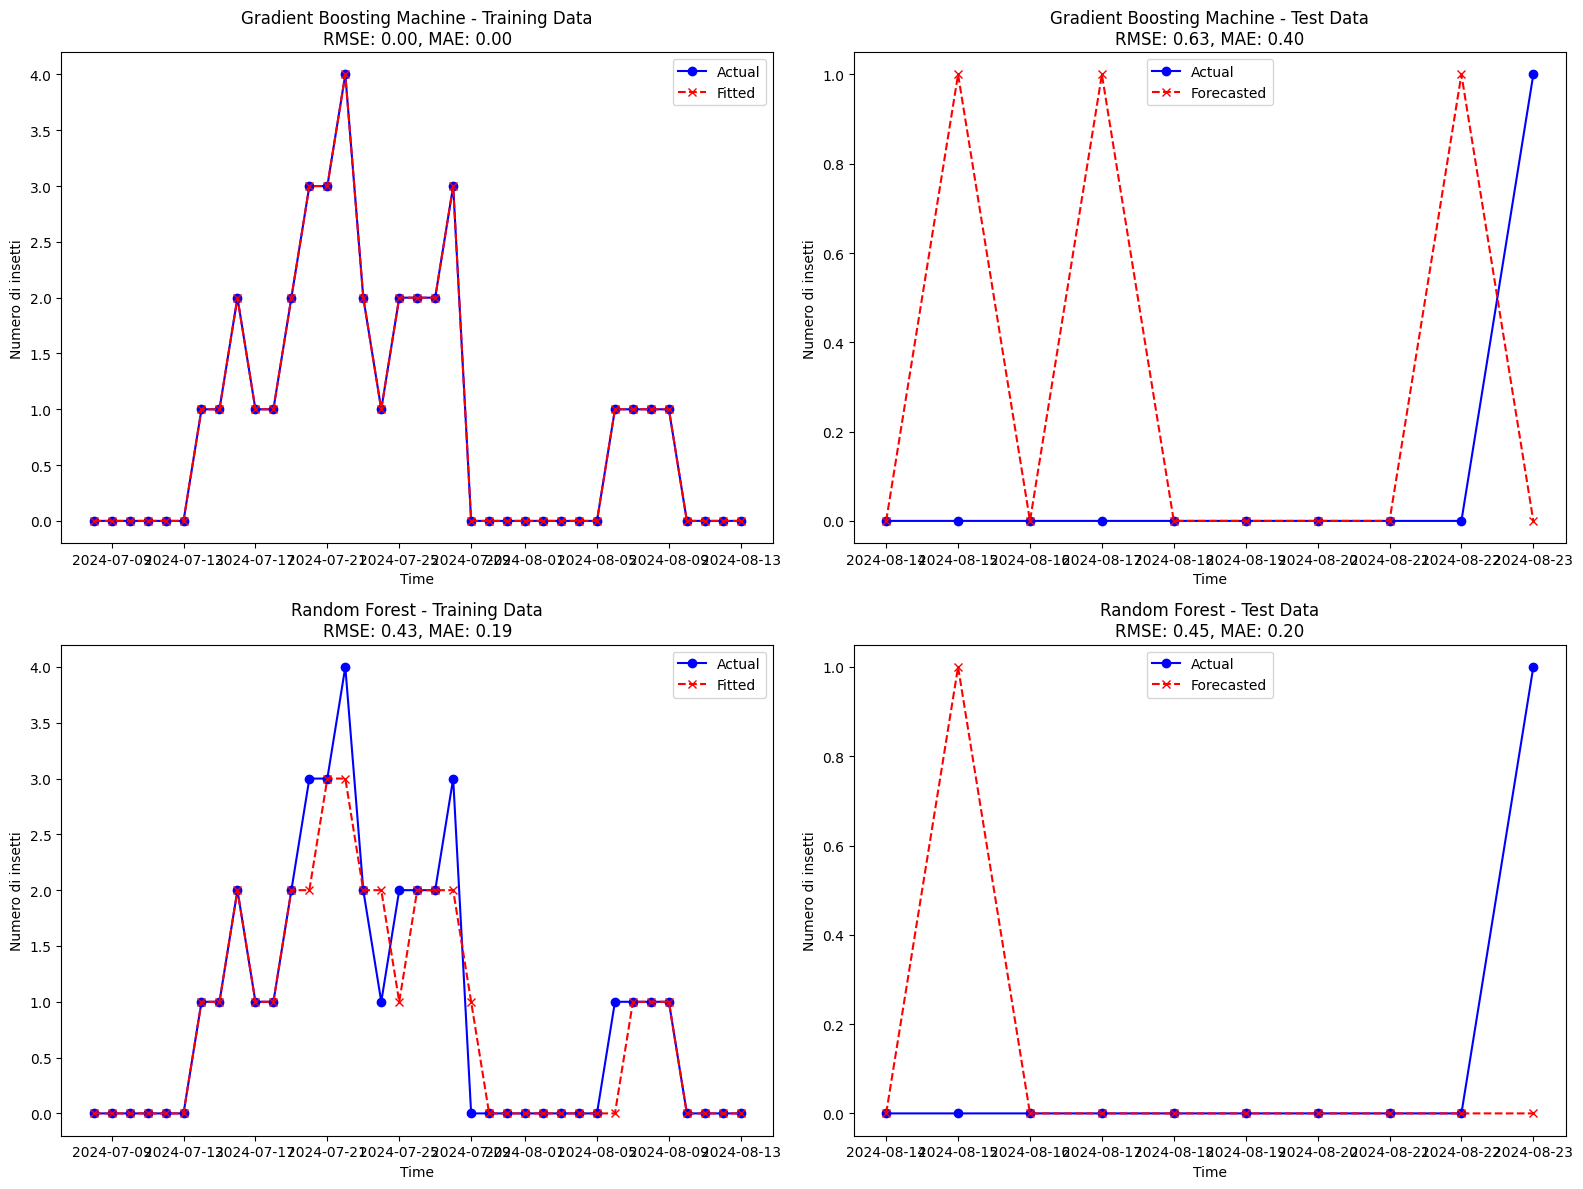

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

rmse_train_ensamble_1 = np.zeros(2)
mae_train_ensamble_1 = np.zeros(2)
rmse_test_ensamble_1 = np.zeros(2)
mae_test_ensamble_1 = np.zeros(2)

def create_lagged_features(df, n_lags=5, target_col='Numero di insetti', exog_cols=[]):
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df[target_col].shift(i)

    df.dropna(inplace=True)
    return df

def train_and_visualize(df, n_lags, exog_cols,target_col):
    df = create_lagged_features(df, n_lags=n_lags, exog_cols=exog_cols)

    feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
    X = df[feature_cols]
    y = df[target_col]

    train_size = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Gradient Boosting Machine": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
        "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3)
    }

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        y_pred_train = np.clip(y_pred_train, 0, None).round()
        y_pred_test = np.clip(y_pred_test, 0, None).round()


        rmse_train_ensamble_1[i] = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train_ensamble_1[i] = mean_absolute_error(y_train, y_pred_train)
        rmse_test_ensamble_1[i] = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test_ensamble_1[i] = mean_absolute_error(y_test, y_pred_test)

        axs[i][0].plot(y_train.index, y_train, label='Actual', marker='o', color='blue')
        axs[i][0].plot(y_train.index, y_pred_train, label='Fitted', linestyle='--', marker='x', color='red')
        axs[i][0].set_title(f'{name} - Training Data\nRMSE: {rmse_train_ensamble_1[i]:.2f}, MAE: {mae_train_ensamble_1[i]:.2f}')
        axs[i][0].set_xlabel('Time')
        axs[i][0].set_ylabel('Numero di insetti')
        axs[i][0].legend()

        axs[i][1].plot(y_test.index, y_test, label='Actual', marker='o', color='blue')
        axs[i][1].plot(y_test.index, y_pred_test, label='Forecasted', linestyle='--', marker='x', color='red')
        axs[i][1].set_title(f'{name} - Test Data\nRMSE: {rmse_test_ensamble_1[i]:.2f}, MAE: {mae_test_ensamble_1[i]:.2f}')
        axs[i][1].set_xlabel('Time')
        axs[i][1].set_ylabel('Numero di insetti')
        axs[i][1].legend()

    plt.tight_layout()
    plt.show()
    return models , df

df_merged_copy = merged_df.copy().drop("Nuove catture (per evento)", axis=1)
exog_cols = ['Media Temperatura', 'Media Umidità']
models , real_data = train_and_visualize(df_merged_copy, n_lags=3, exog_cols=exog_cols, target_col ='Numero di insetti')


I grafici confrontano le prestazioni dei due modelli sui dati di addestramento e di test. Per il **GBM**, sui dati di addestramento, c'è una perfetta corrispondenza tra i valori effettivi e quelli previsti. Per i dati di test, abbiamo un **RMSE** di 0.63 e un **MAE** di 0.40, indicando alcuni errori di previsione ma buoni livelli di accuratezza. Per il modello **Random Forest**, il set di addestramento presenta errori nell'adattamento, ma il suo set di test ha valori migliori di **RMSE** e **MAE**.

In [ ]:
def print_ensamble_metrics(rmse_train_ensamble, mae_train_ensamble, rmse_test_ensamble, mae_test_ensamble):
    """Prints the ensemble model metrics.

    Args:
        rmse_train_ensamble: Array of RMSE values for the training set.
        mae_train_ensamble: Array of MAE values for the training set.
        rmse_test_ensamble: Array of RMSE values for the test set.
        mae_test_ensamble: Array of MAE values for the test set.
    """

    print("Ensemble Model Metrics:")
    print("-----------------------")

    for i in range(len(rmse_train_ensamble)):
        print(f"Model {i + 1}:")
        print(f"  RMSE (Train): {rmse_train_ensamble[i]:.4f}")
        print(f"  MAE (Train): {mae_train_ensamble[i]:.4f}")
        print(f"  RMSE (Test): {rmse_test_ensamble[i]:.4f}")
        print(f"  MAE (Test): {mae_test_ensamble[i]:.4f}")
        print("-----------------------")


print_ensamble_metrics(rmse_train_ensamble_1, mae_train_ensamble_1, rmse_test_ensamble_1, mae_test_ensamble_1)

Ensemble Model Metrics:
-----------------------
Model 1:
  RMSE (Train): 0.0000
  MAE (Train): 0.0000
  RMSE (Test): 0.6325
  MAE (Test): 0.4000
-----------------------
Model 2:
  RMSE (Train): 0.4350
  MAE (Train): 0.1892
  RMSE (Test): 0.4472
  MAE (Test): 0.2000
-----------------------


# Feature Importance : Numero di insetti

Di seguito calcoliamo l'importanza delle caratteristiche (**feature** **importances**) utilizzando il modello **Random** **Forest**. L'importanza ci indica quanto ogni caratteristica contribuisca alle previsioni del modello, possiamo vedere dal grafico che la variabile che influenza maggiormente il modello è *Media Temperatura*.

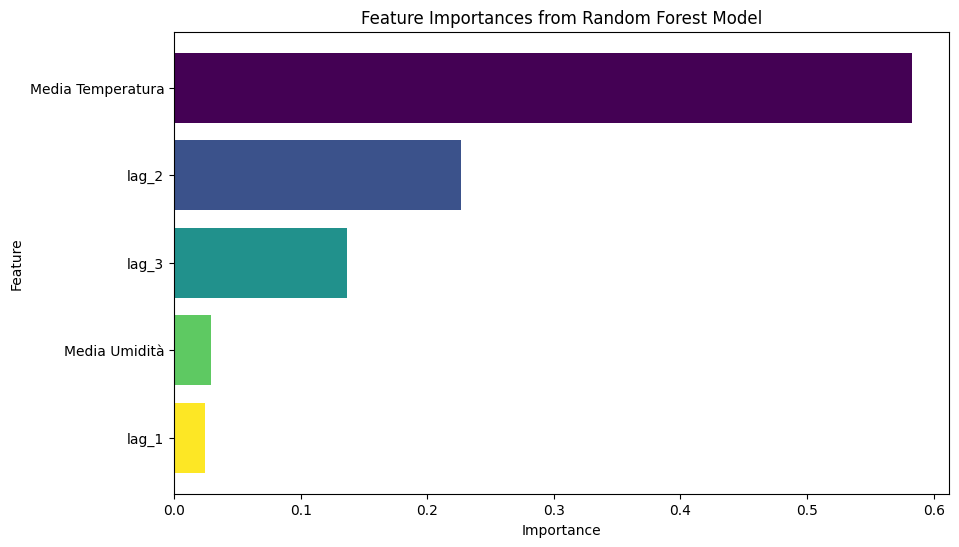

In [ ]:
importances = models['Random Forest'].feature_importances_
feature_names = ['Media Temperatura', 'Media Umidità',
       'lag_1', 'lag_2', 'lag_3']

feature_importances = sorted(zip(importances, feature_names), reverse=True, key=lambda x: x[0])

sorted_importances, sorted_features = zip(*feature_importances)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_importances)))
plt.barh(sorted_features, sorted_importances, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


# Ensemble Learning : Nuove catture (per evento)

Per la seconda variabile target, il numero di lags utilizzati è 4.

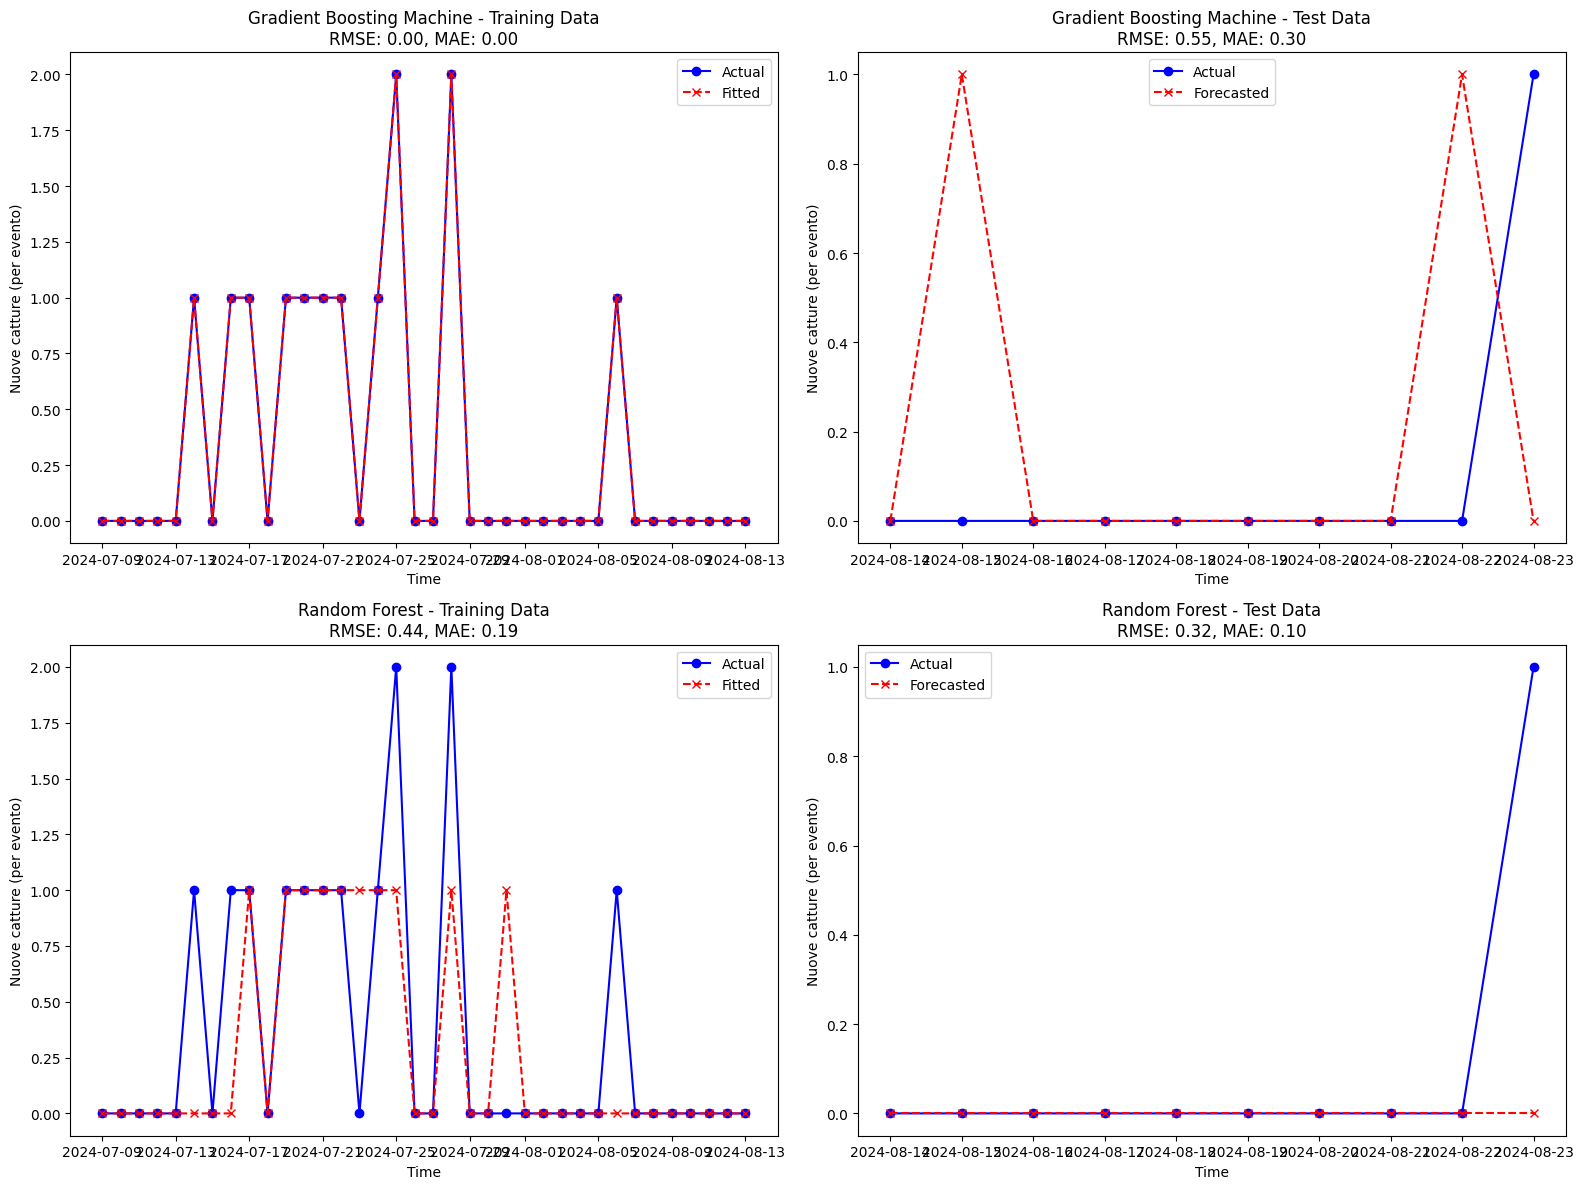

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

rmse_train_ensamble_2 = np.zeros(2)
mae_train_ensamble_2 = np.zeros(2)
rmse_test_ensamble_2 = np.zeros(2)
mae_test_ensamble_2 = np.zeros(2)

def create_lagged_features(df, n_lags=5, target_col='Nuove catture (per evento)', exog_cols=[]):
    """ Create lagged features for the target and use exogenous columns as is. """
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df[target_col].shift(i)

    df.dropna(inplace=True)
    return df

def train_and_visualize(df, n_lags, exog_cols,target_col):
    """ Train models and visualize the results, using exogenous columns without lags. """
    df = create_lagged_features(df, n_lags=n_lags, exog_cols=exog_cols)

    feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
    X = df[feature_cols]
    y = df[target_col]

    train_size = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Gradient Boosting Machine": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
        "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3)
    }

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        y_pred_train = np.clip(y_pred_train, 0, None).round()
        y_pred_test = np.clip(y_pred_test, 0, None).round()

        rmse_train_ensamble_2[i] = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train_ensamble_2[i] = mean_absolute_error(y_train, y_pred_train)
        rmse_test_ensamble_2[i] = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test_ensamble_2[i] = mean_absolute_error(y_test, y_pred_test)

        axs[i][0].plot(y_train.index, y_train, label='Actual', marker='o', color='blue')
        axs[i][0].plot(y_train.index, y_pred_train, label='Fitted', linestyle='--', marker='x', color='red')
        axs[i][0].set_title(f'{name} - Training Data\nRMSE: {rmse_train_ensamble_2[i]:.2f}, MAE: {mae_train_ensamble_2[i]:.2f}')
        axs[i][0].set_xlabel('Time')
        axs[i][0].set_ylabel('Nuove catture (per evento)')
        axs[i][0].legend()

        axs[i][1].plot(y_test.index, y_test, label='Actual', marker='o', color='blue')
        axs[i][1].plot(y_test.index, y_pred_test, label='Forecasted', linestyle='--', marker='x', color='red')
        axs[i][1].set_title(f'{name} - Test Data\nRMSE: {rmse_test_ensamble_2[i]:.2f}, MAE: {mae_test_ensamble_2[i]:.2f}')
        axs[i][1].set_xlabel('Time')
        axs[i][1].set_ylabel('Nuove catture (per evento)')
        axs[i][1].legend()

    plt.tight_layout()
    plt.show()
    return models , df

df_merged_copy_2 = merged_df.copy().drop('Numero di insetti', axis=1)
exog_cols = ['Media Temperatura', 'Media Umidità']
models_2, real_data_2 = train_and_visualize(df_merged_copy_2, n_lags=4, exog_cols=exog_cols, target_col ='Nuove catture (per evento)')


# Feature Importance : *Nuove catture (per evento)*

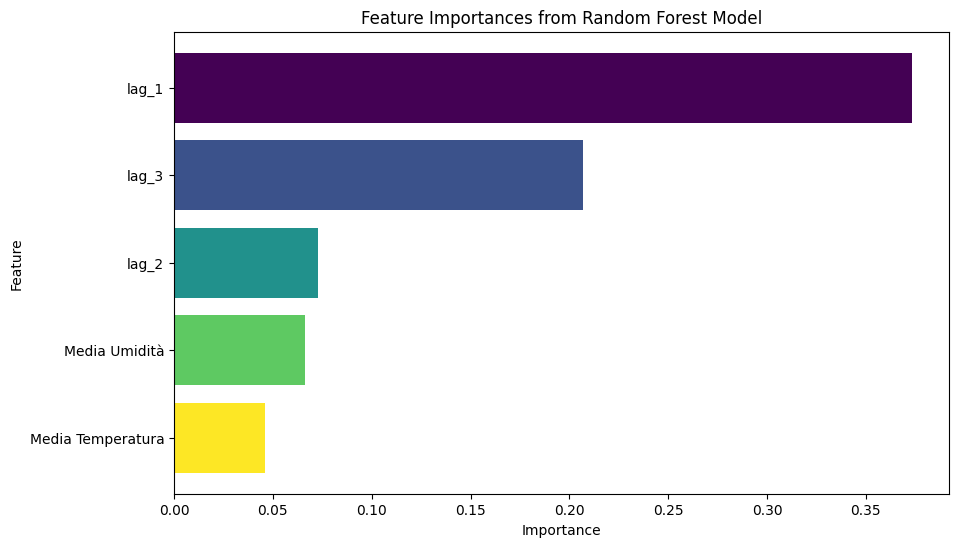

In [ ]:
importances = models_2['Random Forest'].feature_importances_
feature_names = ['Media Temperatura', 'Media Umidità',
       'lag_1', 'lag_2', 'lag_3']

feature_importances = sorted(zip(importances, feature_names), reverse=True, key=lambda x: x[0])

sorted_importances, sorted_features = zip(*feature_importances)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_importances)))
plt.barh(sorted_features, sorted_importances, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


#  MLP-Lagged Regressor : *Numero di insetti*
Il modello che segue è una rete neurale Multi-Layer Perceptron (**MLP**) utilizzato per prevedere il Numero di insetti, sfruttando come input le variabili laggate. In particolare, vengono create 3 variabili lag, oltre ad includere variabili esogene come *Media Temperatura e Media Umidità*. La variabile target è *Numero di insetti.*

Per preparare i dati, vengono normalizzati affinché abbiano media 0 e deviazione standard 1, un passaggio fondamentale per migliorare le prestazioni dei modelli basati su reti neurali.

Il modello **MLP** viene definito utilizzando l'API funzionale di **TensorFlow** e comprende due strati completamente connessi, rispettivamente con 5 e 30 neuroni. Per l'ottimizzazione, viene utilizzato l'ottimizzatore **Adam**, mentre la funzione di perdita è **MSE** (Mean Squared Error), che misura la discrepanza tra le previsioni e i valori reali e che il modello cerca di minimizzare durante l'allenamento.

Il modello viene allenato su 200 epoche con una dimensione del batch di 32, per un'efficace convergenza e ottimizzazione delle previsioni.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


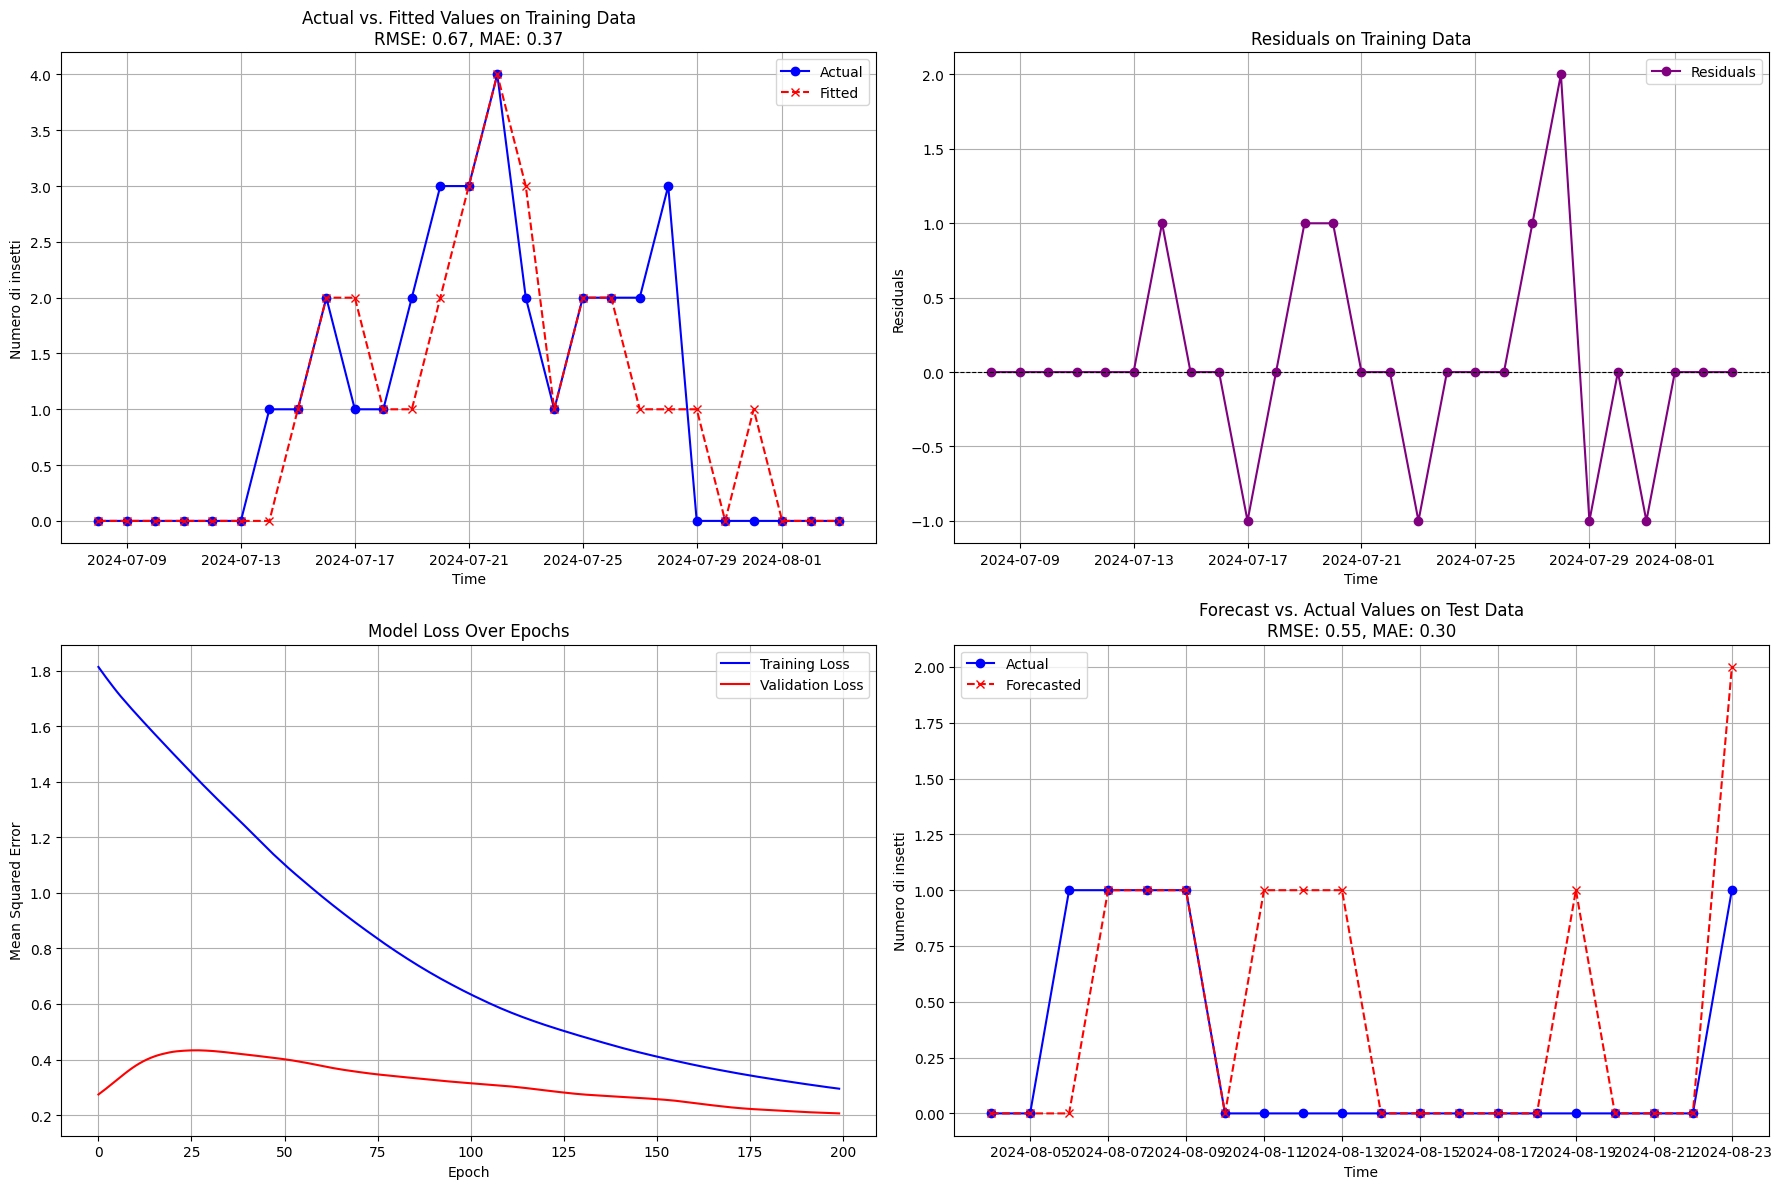

In [ ]:

def create_lagged_features(df, n_lags=5, target_col='Numero di insetti', exog_cols=[]):
    lagged_df = df.copy()
    for i in range(1, n_lags + 1):
        lagged_df[f'lag_{i}'] = lagged_df[target_col].shift(i)
    lagged_df = lagged_df.dropna()
    return lagged_df

n_lags = 3
exog_cols = ['Media Temperatura', 'Media Umidità']

df_copy_1 = merged_df.copy().drop('Nuove catture (per evento)', axis=1)

lagged_df = create_lagged_features(df_copy_1, n_lags=n_lags, target_col='Numero di insetti', exog_cols=exog_cols)


feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
X = lagged_df[feature_cols]
y = lagged_df['Numero di insetti']

train_size = len(lagged_df) - 20
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
x = tf.keras.layers.Dense(5, activation='relu')(inputs)
x = tf.keras.layers.Dense(30, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model_mlp = tf.keras.Model(inputs=inputs, outputs=outputs)

model_mlp.compile(optimizer='adam', loss='mean_squared_error')

history = model_mlp.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=0
)


y_train_pred = model_mlp.predict(X_train_scaled)
y_test_pred = model_mlp.predict(X_test_scaled)

y_train_pred_processed = np.clip(y_train_pred.flatten(), 0, None).round()
y_test_pred_processed = np.clip(y_test_pred.flatten(), 0, None).round()

rmse_train_MLP_1 = np.sqrt(mean_squared_error(y_train, y_train_pred_processed))
mae_train_MLP_1 = mean_absolute_error(y_train, y_train_pred_processed)

rmse_test_MLP_1 = np.sqrt(mean_squared_error(y_test, y_test_pred_processed))
mae_test_MLP_1 = mean_absolute_error(y_test, y_test_pred_processed)

residuals_train = y_train - y_train_pred_processed

y_train_index = y_train.index
y_test_index = y_test.index

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].plot(y_train_index, y_train, label='Actual', color='blue', marker='o')
axs[0, 0].plot(y_train_index, y_train_pred_processed, label='Fitted', color='red', linestyle='--', marker='x')
axs[0, 0].set_title(f'Actual vs. Fitted Values on Training Data\nRMSE: {rmse_train_MLP_1:.2f}, MAE: {mae_train_MLP_1:.2f}')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Numero di insetti')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(y_train_index, residuals_train, label='Residuals', color='purple', marker='o')
axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axs[0, 1].set_title('Residuals on Training Data')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1, 0].set_title('Model Loss Over Epochs')
axs[1, 0].set_ylabel('Mean Squared Error')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(y_test_index, y_test.values, label='Actual', marker='o', color='blue')
axs[1, 1].plot(y_test_index, y_test_pred_processed, label='Forecasted', marker='x', linestyle='--', color='red')
axs[1, 1].set_title(f'Forecast vs. Actual Values on Test Data\nRMSE: {rmse_test_MLP_1:.2f}, MAE: {mae_test_MLP_1:.2f}')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Numero di insetti')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


Il grafico **Actual vs Fitted Values on Training Data** mostra che il modello ha fatto un buon lavoro nell'apprendere dai dati di addestramento (**RMSE**: 0.82, **MAE**: 0.59). Sui dati di test, i valori migliorano ulteriormente, suggerendo che il modello generalizza bene anche sui dati di test. Gli altri due grafici mostrano graficamente i residui nei rispettivi set di dati.

In [ ]:
model_mlp.save('trained_mlp_1.h5')

# MLP-Lagged Regressor : *Nuove catture (per evento)*


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


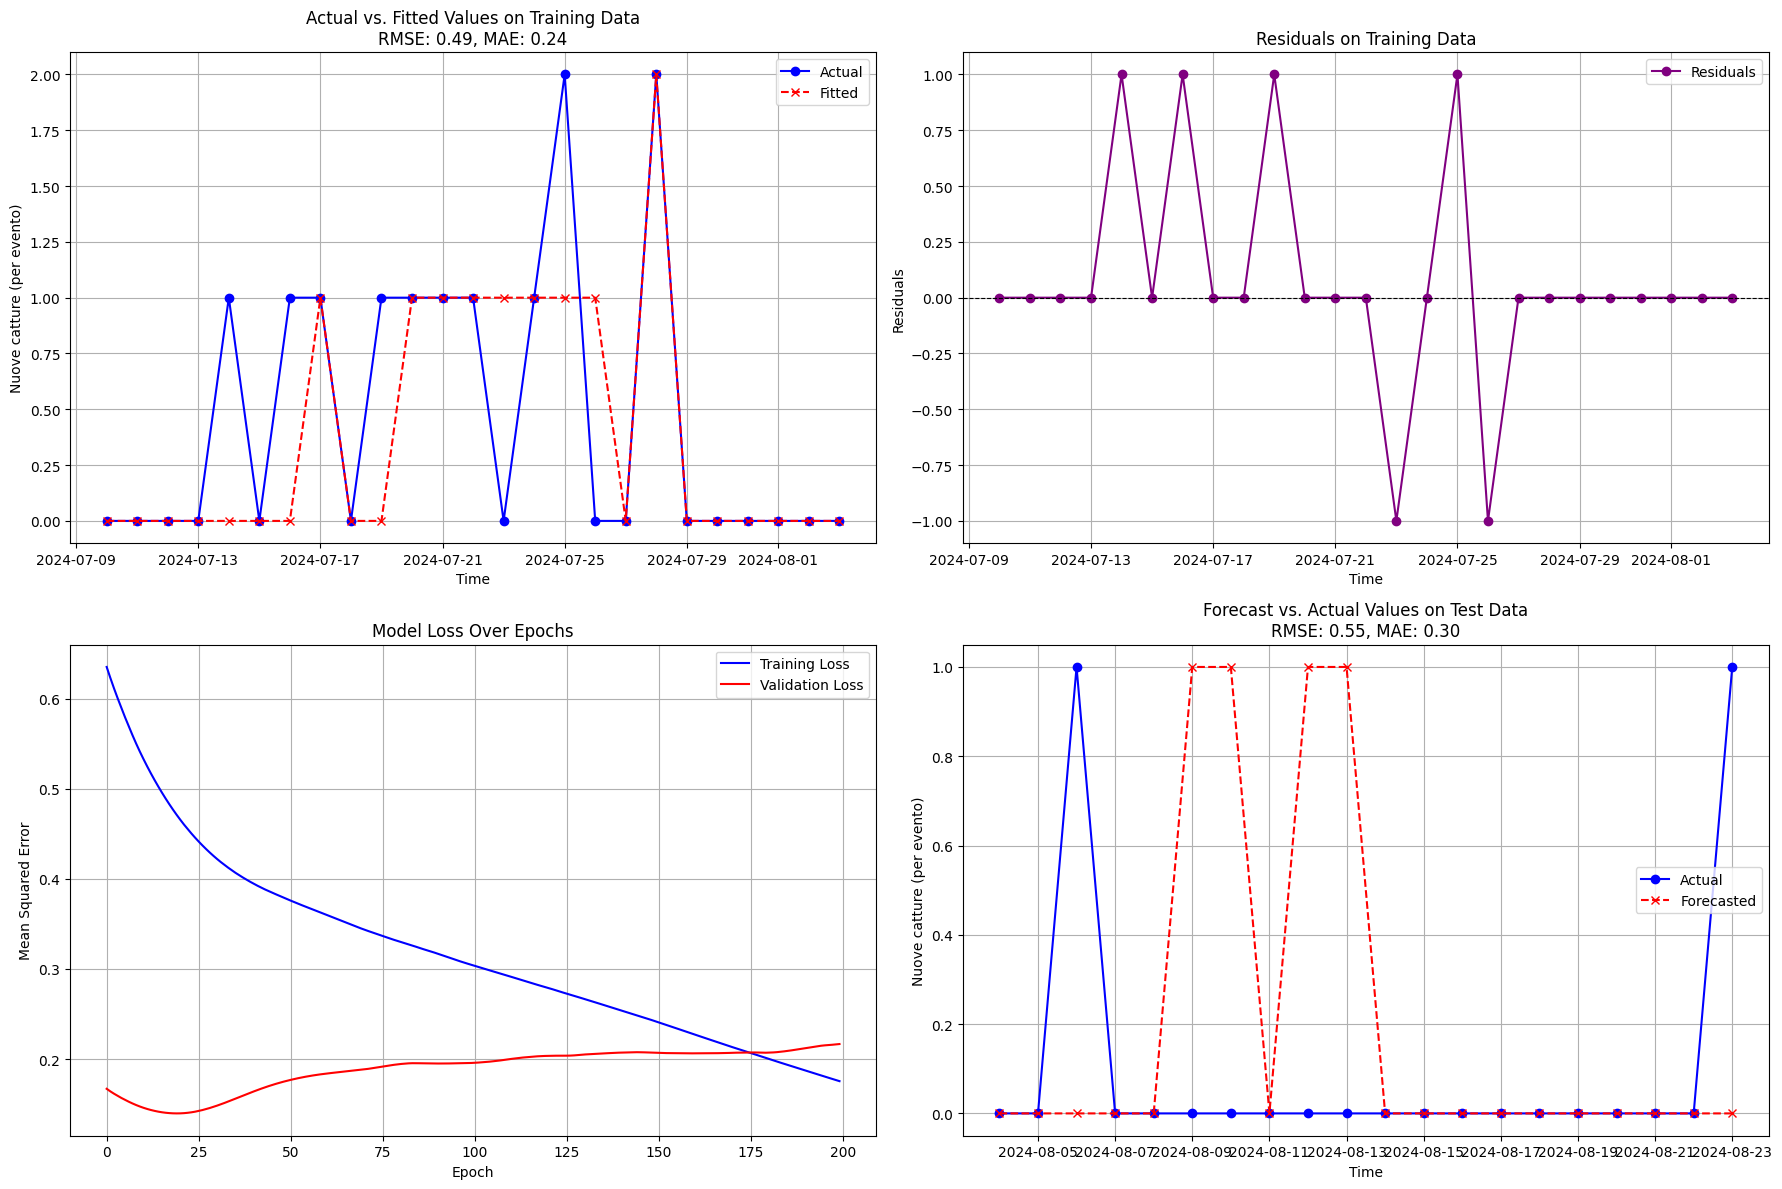

In [ ]:
def create_lagged_features(df, n_lags=5, target_col='Nuove catture (per evento)', exog_cols=[]):
    lagged_df = df.copy()
    for i in range(1, n_lags + 1):
        lagged_df[f'lag_{i}'] = lagged_df[target_col].shift(i)
    lagged_df = lagged_df.dropna()
    return lagged_df

n_lags = 5
exog_cols = ['Media Temperatura', 'Media Umidità']

df_copy_1 = merged_df.copy().drop('Numero di insetti', axis=1)
lagged_df = create_lagged_features(df_copy_1, n_lags=n_lags, target_col='Nuove catture (per evento)', exog_cols=exog_cols)

feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
X = lagged_df[feature_cols]
y = lagged_df['Nuove catture (per evento)']


train_size = len(lagged_df) - 20
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
x = tf.keras.layers.Dense(5, activation='relu')(inputs)
x = tf.keras.layers.Dense(30, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model_mlp = tf.keras.Model(inputs=inputs, outputs=outputs)

model_mlp.compile(optimizer='adam', loss='mean_squared_error')

history = model_mlp.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=0
)

y_train_pred = model_mlp.predict(X_train_scaled)
y_test_pred = model_mlp.predict(X_test_scaled)

y_train_pred_processed = np.clip(y_train_pred.flatten(), 0, None).round()
y_test_pred_processed = np.clip(y_test_pred.flatten(), 0, None).round()

rmse_train_MLP_2 = np.sqrt(mean_squared_error(y_train, y_train_pred_processed))
mae_train_MLP_2 = mean_absolute_error(y_train, y_train_pred_processed)

rmse_test_MLP_2 = np.sqrt(mean_squared_error(y_test, y_test_pred_processed))
mae_test_MLP_2 = mean_absolute_error(y_test, y_test_pred_processed)

residuals_train = y_train - y_train_pred_processed

y_train_index = y_train.index
y_test_index = y_test.index

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].plot(y_train_index, y_train, label='Actual', color='blue', marker='o')
axs[0, 0].plot(y_train_index, y_train_pred_processed, label='Fitted', color='red', linestyle='--', marker='x')
axs[0, 0].set_title(f'Actual vs. Fitted Values on Training Data\nRMSE: {rmse_train_MLP_2:.2f}, MAE: {mae_train_MLP_2:.2f}')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Nuove catture (per evento)')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(y_train_index, residuals_train, label='Residuals', color='purple', marker='o')
axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axs[0, 1].set_title('Residuals on Training Data')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1, 0].set_title('Model Loss Over Epochs')
axs[1, 0].set_ylabel('Mean Squared Error')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(y_test_index, y_test.values, label='Actual', marker='o', color='blue')
axs[1, 1].plot(y_test_index, y_test_pred_processed, label='Forecasted', marker='x', linestyle='--', color='red')
axs[1, 1].set_title(f'Forecast vs. Actual Values on Test Data\nRMSE: {rmse_test_MLP_2:.2f}, MAE: {mae_test_MLP_2:.2f}')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Nuove catture (per evento)')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model_mlp.save('trained_mlp_2.h5')

# Long-Short Term Memory : *Numero di insetti*

L'ultimo modello di Deep Learning che utilizziamo è basato su Long Short-Term Memory (**LSTM**) per la previsione del *Numero di insetti*. Anche in questo caso, creo una serie di feature lag fino a 5 periodi indietro. In pratica, per ciascuna variabile, sia essa target (*Numero di insetti*) o esogena (come la temperatura e l'umidità), vengono create nuove colonne che rappresentano i valori ritardati fino a 5 periodi precedenti.

Successivamente, in **X_list** inserisco i dati, creando una lista di array in cui ogni array rappresenta le caratteristiche (*feature*) per un determinato ritardo temporale. Questo processo consente di preparare i dati in modo che il modello **LSTM** possa apprendere le dipendenze temporali tra le osservazioni.

La funzione *np.stack* viene quindi utilizzata per combinare gli array di **X_list** lungo la dimensione temporale, creando un array tridimensionale della forma (*numero di osservazioni, numero di lag, numero di feature*). In questo modo, otteniamo i dati strutturati in modo tale che il modello LSTM possa trattarli come sequenze temporali.

Successivamente, suddivido l'array ottenuto in set di training e testing.

Per quanto riguarda il modello **LSTM**, lo costruisco con 50 unità (neuroni) nel layer **LSTM**, utilizzando la funzione di attivazione **ReLU** per garantire una non linearità nelle previsioni. A seguire, un layer denso permette di ottenere la previsione finale del *Numero di insetti*. Il modello viene compilato con l'ottimizzatore **Adam** e la funzione di errore **MSE** (Mean Squared Error), che viene utilizzata come funzione di perdita per ottimizzare i pesi del modello.

Il modello viene allenato per 25 epoche, monitorando la sua performance sui dati di test durante l'allenamento.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


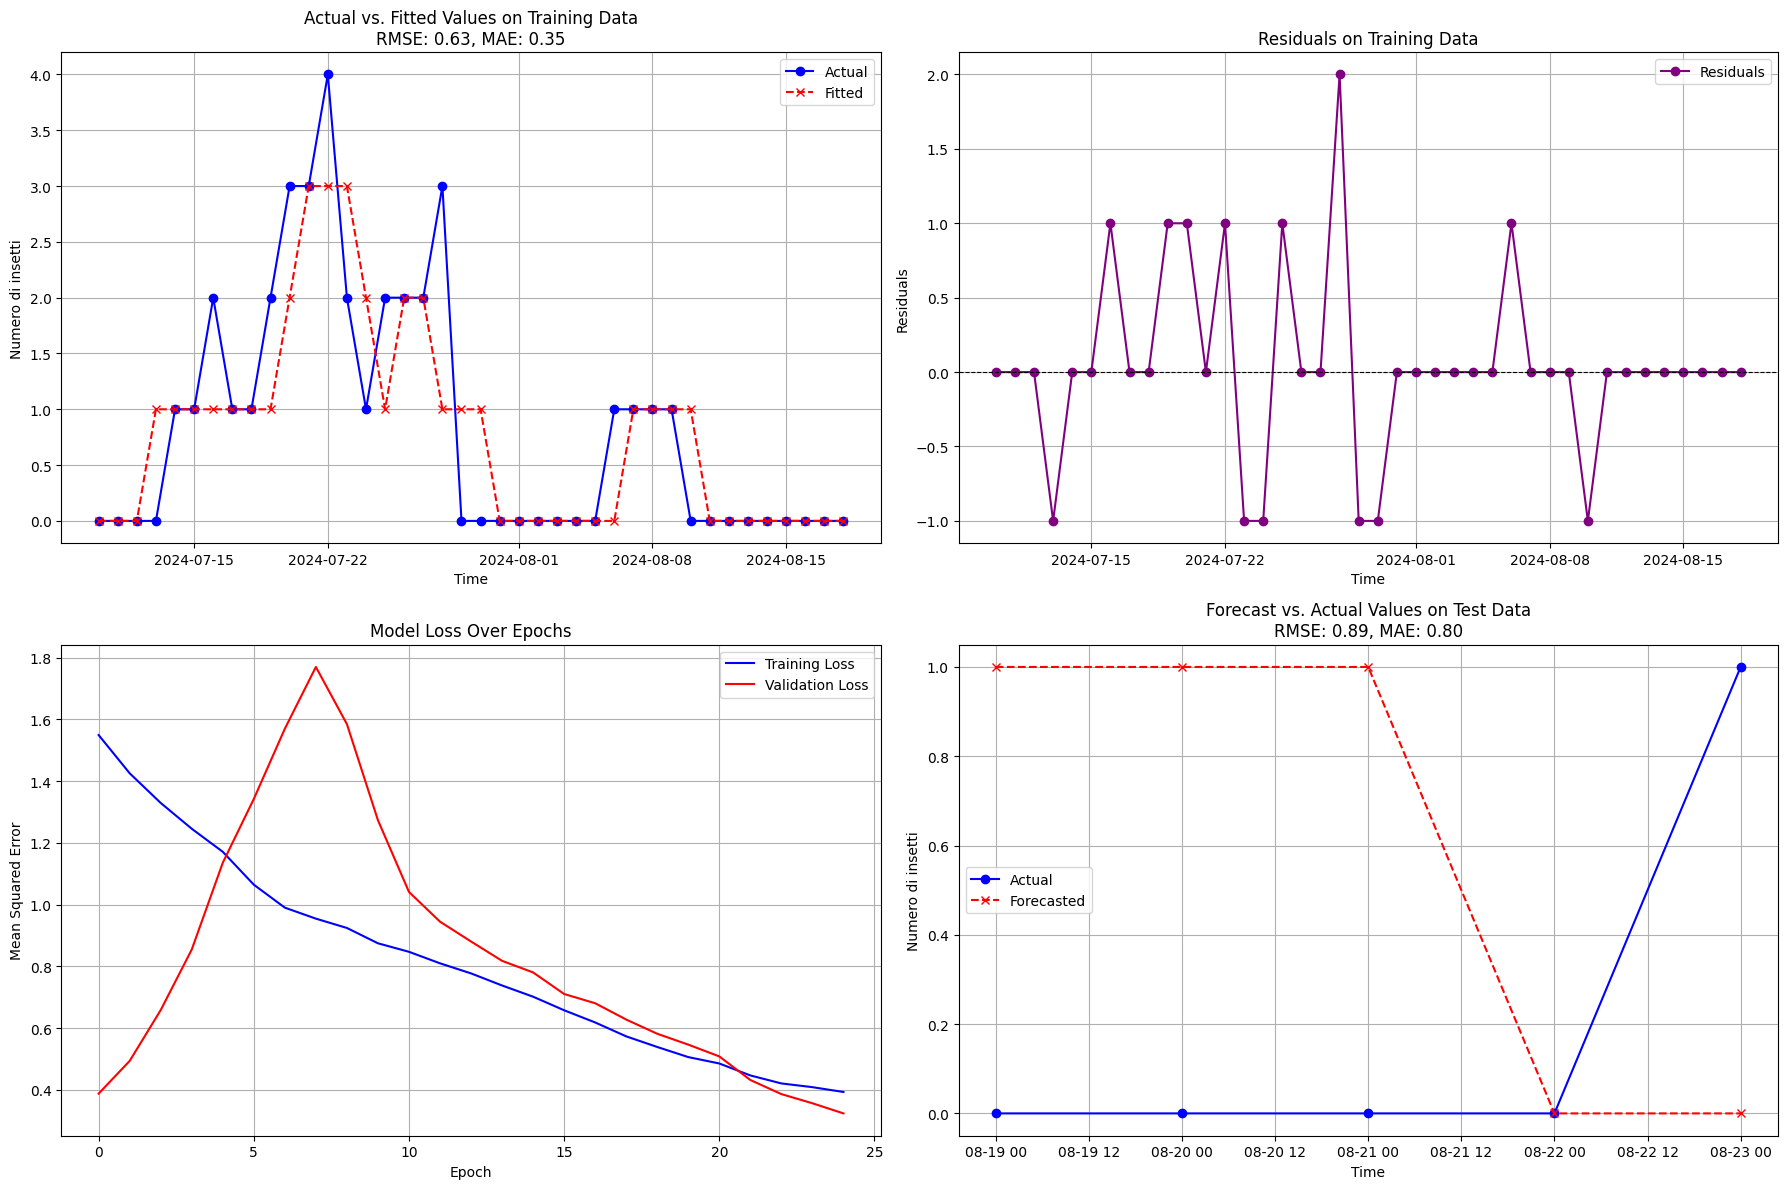

In [ ]:

def create_lagged_features(df, n_lags=5, target_col='Numero di insetti', exog_cols=[]):
    lagged_df = df.copy()
    for col in [target_col] + exog_cols:
        for i in range(1, n_lags + 1):
            lagged_df[f'{col}_lag_{i}'] = lagged_df[col].shift(i)
    lagged_df = lagged_df.dropna()
    return lagged_df

n_lags = 5
exog_cols = ['Media Temperatura', 'Media Umidità']

df_copy_1 = merged_df.copy().drop('Nuove catture (per evento)', axis=1)
lagged_df = create_lagged_features(df_copy_1, n_lags=n_lags, target_col='Numero di insetti', exog_cols=exog_cols)

variables = ['Numero di insetti'] + exog_cols

timestep_cols = []
for t in range(n_lags):
    lag = n_lags - t
    cols = [f'{var}_lag_{lag}' for var in variables]
    timestep_cols.append(cols)

X_list = [lagged_df[cols].values for cols in timestep_cols]
X = np.stack(X_list, axis=1)

y = lagged_df['Numero di insetti'].values

train_size = len(lagged_df) - 5
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

n_train_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(n_train_samples, n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], n_timesteps, n_features)

inputs = tf.keras.Input(shape=(n_timesteps, n_features))
x = tf.keras.layers.LSTM(50, activation='relu')(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=outputs)

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

history = model_lstm.fit(
    X_train_scaled, y_train,
    epochs=25,
    batch_size=8,
    validation_data=(X_test_scaled, y_test),
    verbose=0
)

y_train_pred = model_lstm.predict(X_train_scaled)
y_test_pred = model_lstm.predict(X_test_scaled)

y_train_pred_processed = np.clip(y_train_pred.flatten(), 0, None).round()
y_test_pred_processed = np.clip(y_test_pred.flatten(), 0, None).round()

rmse_train_LSTM_1 = np.sqrt(mean_squared_error(y_train, y_train_pred_processed))
mae_train_LSTM_1 = mean_absolute_error(y_train, y_train_pred_processed)

rmse_test_LSTM_1  = np.sqrt(mean_squared_error(y_test, y_test_pred_processed))
mae_test_LSTM_1  = mean_absolute_error(y_test, y_test_pred_processed)

residuals_train = y_train - y_train_pred_processed

y_train_index = lagged_df.index[:train_size]
y_test_index = lagged_df.index[train_size:]

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].plot(y_train_index, y_train, label='Actual', color='blue', marker='o')
axs[0, 0].plot(y_train_index, y_train_pred_processed, label='Fitted', color='red', linestyle='--', marker='x')
axs[0, 0].set_title(f'Actual vs. Fitted Values on Training Data\nRMSE: {rmse_train_LSTM_1:.2f}, MAE: {mae_train_LSTM_1:.2f}')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Numero di insetti')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(y_train_index, residuals_train, label='Residuals', color='purple', marker='o')
axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axs[0, 1].set_title('Residuals on Training Data')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1, 0].set_title('Model Loss Over Epochs')
axs[1, 0].set_ylabel('Mean Squared Error')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(y_test_index, y_test, label='Actual', marker='o', color='blue')
axs[1, 1].plot(y_test_index, y_test_pred_processed, label='Forecasted', marker='x', linestyle='--', color='red')
axs[1, 1].set_title(f'Forecast vs. Actual Values on Test Data\nRMSE: {rmse_test_LSTM_1:.2f}, MAE: {mae_test_LSTM_1:.2f}')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Numero di insetti')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model_lstm.save("model_lstm_1.h5")

# Confronto Performance :  Previsione  *Numero di insetti*
Creo un grafico a barre per confrontare le performance dei diversi modelli (**ARMAX, VARMAX, GBM, Random Forest, MLP, LSTM**) nella previsione della variabile target "Numero di insetti", utilizzando le metriche di valutazione **RMSE**  e **MAE**  precedentemente calcolate. Il grafico permette di
visualizzare e confrontare l'accuratezza di ciascun modello, sia sui dati di allenamento che sui dati di test, evidenziando le differenze nelle performance tra le diverse tecniche utilizzate.

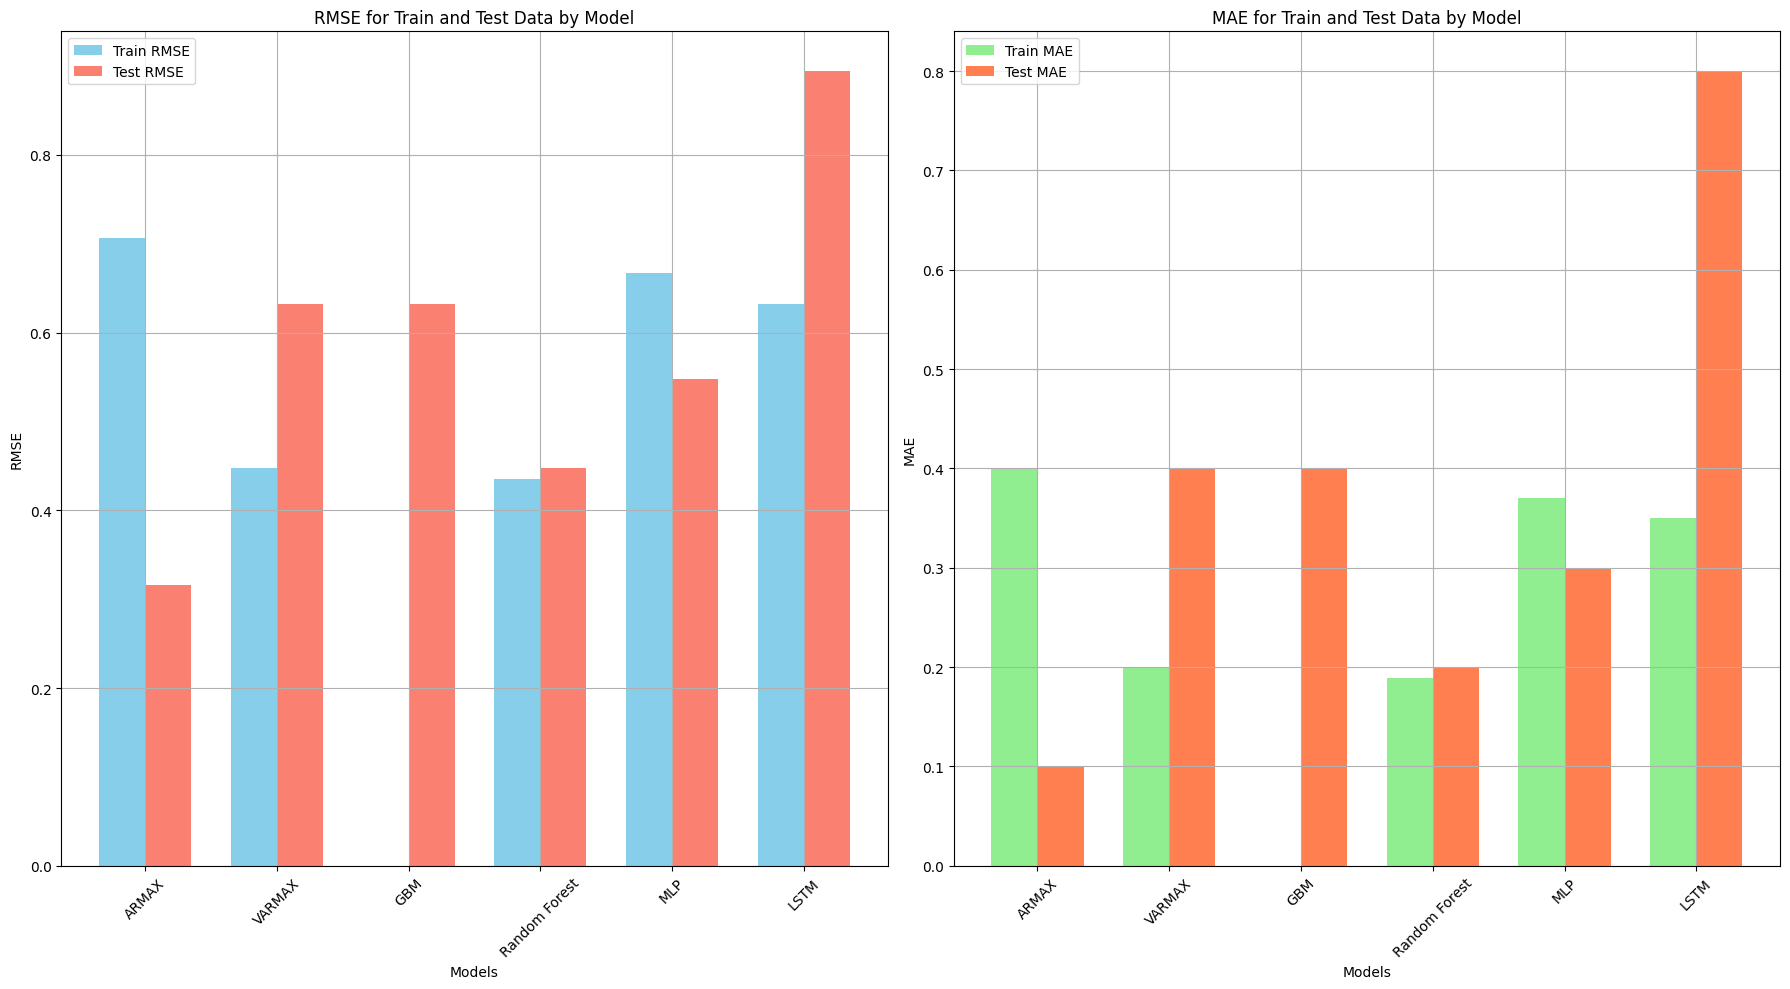

In [ ]:

models = ["ARMAX", "VARMAX", "GBM", "Random Forest", "MLP", "LSTM"]

train_rmse = [rmse_train_arima_1,rmse_train_varima_1,rmse_train_ensamble_1[0],rmse_train_ensamble_1[1],rmse_train_MLP_1,rmse_train_LSTM_1]  # Example values
test_rmse = [rmse_test_arima_1,rmse_test_varima_1,rmse_test_ensamble_1[0],rmse_test_ensamble_1[1],rmse_test_MLP_1,rmse_test_LSTM_1]

train_mae = [mae_train_arima_1,mae_train_varima_1,mae_train_ensamble_1[0],mae_train_ensamble_1[1],mae_train_MLP_1,mae_train_LSTM_1]
test_mae = [mae_test_arima_1,mae_test_varima_1,mae_test_ensamble_1[0],mae_test_ensamble_1[1],mae_test_MLP_1,mae_test_LSTM_1]


x = np.arange(len(models))
width = 0.35
fig, axs = plt.subplots(1, 2, figsize=(18, 10))

axs[0].bar(x - width/2, train_rmse, width, label='Train RMSE', color='skyblue')
axs[0].bar(x + width/2, test_rmse, width, label='Test RMSE', color='salmon')
axs[0].set_xlabel('Models')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE for Train and Test Data by Model')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45)
axs[0].legend()
axs[0].grid(True)

axs[1].bar(x - width/2, train_mae, width, label='Train MAE', color='lightgreen')
axs[1].bar(x + width/2, test_mae, width, label='Test MAE', color='coral')
axs[1].set_xlabel('Models')
axs[1].set_ylabel('MAE')
axs[1].set_title('MAE for Train and Test Data by Model')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Esaminando i due grafici che confrontano **RMSE** e **MAE** per i set di allenamento e di test, si osserva che, per il set di test, il modello **ARMAX** presenta i migliori valori sia per **RMSE** che per **MAE**. Inoltre, come già osservato in precedenza, il modello **GBM** mostra valori pari a zero sia per **RMSE** che per **MAE** nel set di allenamento.

# Long-Short Term Memory : *Nuove catture (per evento)*

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


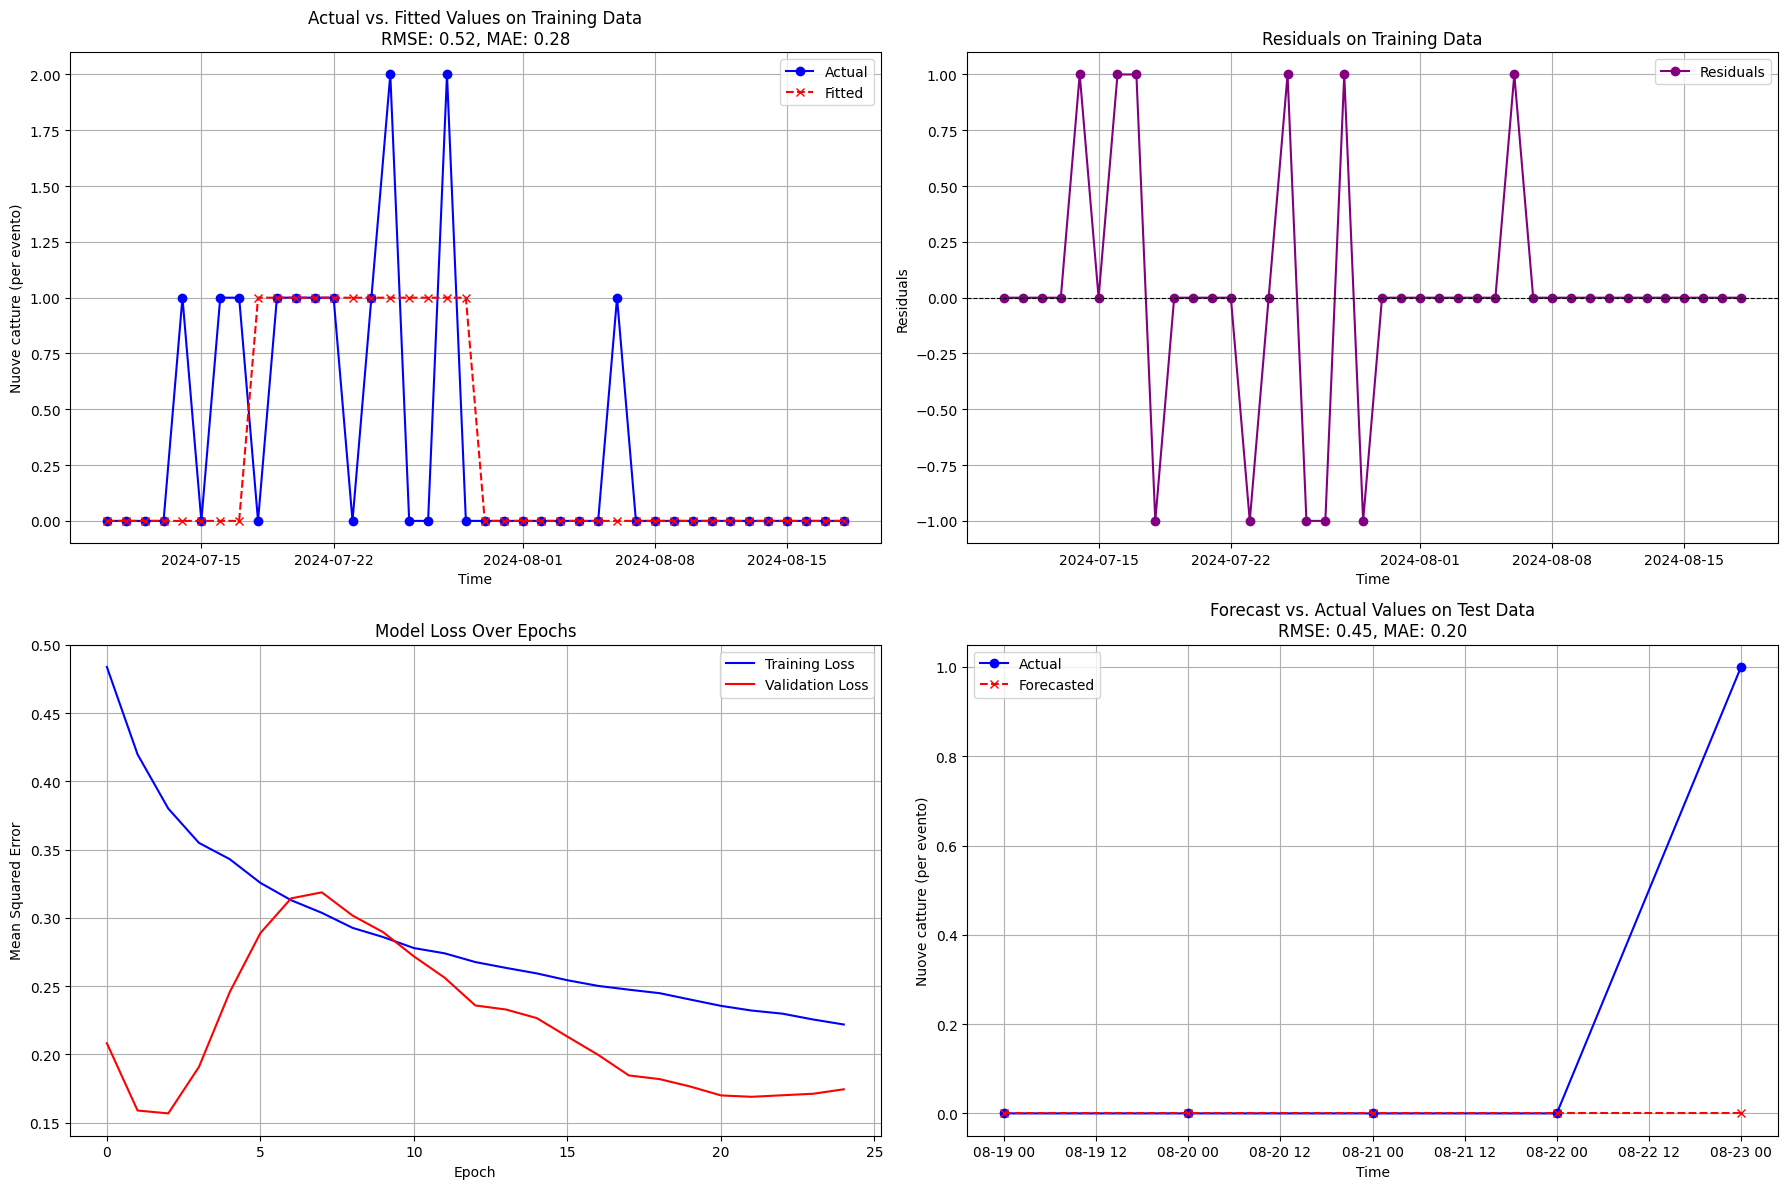

In [ ]:

def create_lagged_features(df, n_lags=5, target_col='Nuove catture (per evento)', exog_cols=[]):
    lagged_df = df.copy()
    for col in [target_col] + exog_cols:
        for i in range(1, n_lags + 1):
            lagged_df[f'{col}_lag_{i}'] = lagged_df[col].shift(i)
    lagged_df = lagged_df.dropna()
    return lagged_df

n_lags = 5
exog_cols = ['Media Temperatura', 'Media Umidità']

df_copy_1 = merged_df.copy().drop('Numero di insetti', axis=1)
lagged_df = create_lagged_features(df_copy_1, n_lags=n_lags, target_col='Nuove catture (per evento)', exog_cols=exog_cols)


variables = ['Nuove catture (per evento)'] + exog_cols

timestep_cols = []
for t in range(n_lags):
    lag = n_lags - t
    cols = [f'{var}_lag_{lag}' for var in variables]
    timestep_cols.append(cols)


X_list = [lagged_df[cols].values for cols in timestep_cols]
X = np.stack(X_list, axis=1)


y = lagged_df['Nuove catture (per evento)'].values

train_size = len(lagged_df) - 5
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

n_train_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]


X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(n_train_samples, n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], n_timesteps, n_features)

inputs = tf.keras.Input(shape=(n_timesteps, n_features))
x = tf.keras.layers.LSTM(50, activation='relu')(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=outputs)

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

history = model_lstm.fit(
    X_train_scaled, y_train,
    epochs=25,
    batch_size=8,
    validation_data=(X_test_scaled, y_test),
    verbose=0
)

y_train_pred = model_lstm.predict(X_train_scaled)
y_test_pred = model_lstm.predict(X_test_scaled)

y_train_pred_processed = np.clip(y_train_pred.flatten(), 0, None).round()
y_test_pred_processed = np.clip(y_test_pred.flatten(), 0, None).round()

rmse_train_LSTM_2 = np.sqrt(mean_squared_error(y_train, y_train_pred_processed))
mae_train_LSTM_2 = mean_absolute_error(y_train, y_train_pred_processed)

rmse_test_LSTM_2  = np.sqrt(mean_squared_error(y_test, y_test_pred_processed))
mae_test_LSTM_2  = mean_absolute_error(y_test, y_test_pred_processed)

residuals_train = y_train - y_train_pred_processed

y_train_index = lagged_df.index[:train_size]
y_test_index = lagged_df.index[train_size:]

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].plot(y_train_index, y_train, label='Actual', color='blue', marker='o')
axs[0, 0].plot(y_train_index, y_train_pred_processed, label='Fitted', color='red', linestyle='--', marker='x')
axs[0, 0].set_title(f'Actual vs. Fitted Values on Training Data\nRMSE: {rmse_train_LSTM_2:.2f}, MAE: {mae_train_LSTM_2:.2f}')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Nuove catture (per evento)')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(y_train_index, residuals_train, label='Residuals', color='purple', marker='o')
axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axs[0, 1].set_title('Residuals on Training Data')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1, 0].set_title('Model Loss Over Epochs')
axs[1, 0].set_ylabel('Mean Squared Error')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(y_test_index, y_test, label='Actual', marker='o', color='blue')
axs[1, 1].plot(y_test_index, y_test_pred_processed, label='Forecasted', marker='x', linestyle='--', color='red')
axs[1, 1].set_title(f'Forecast vs. Actual Values on Test Data\nRMSE: {rmse_test_LSTM_2:.2f}, MAE: {mae_test_LSTM_2:.2f}')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Nuove catture (per evento)')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model_lstm.save("model_lstm_2.h5")

# Confronto Performance :  Previsione  *Nuove catture (per evento)*


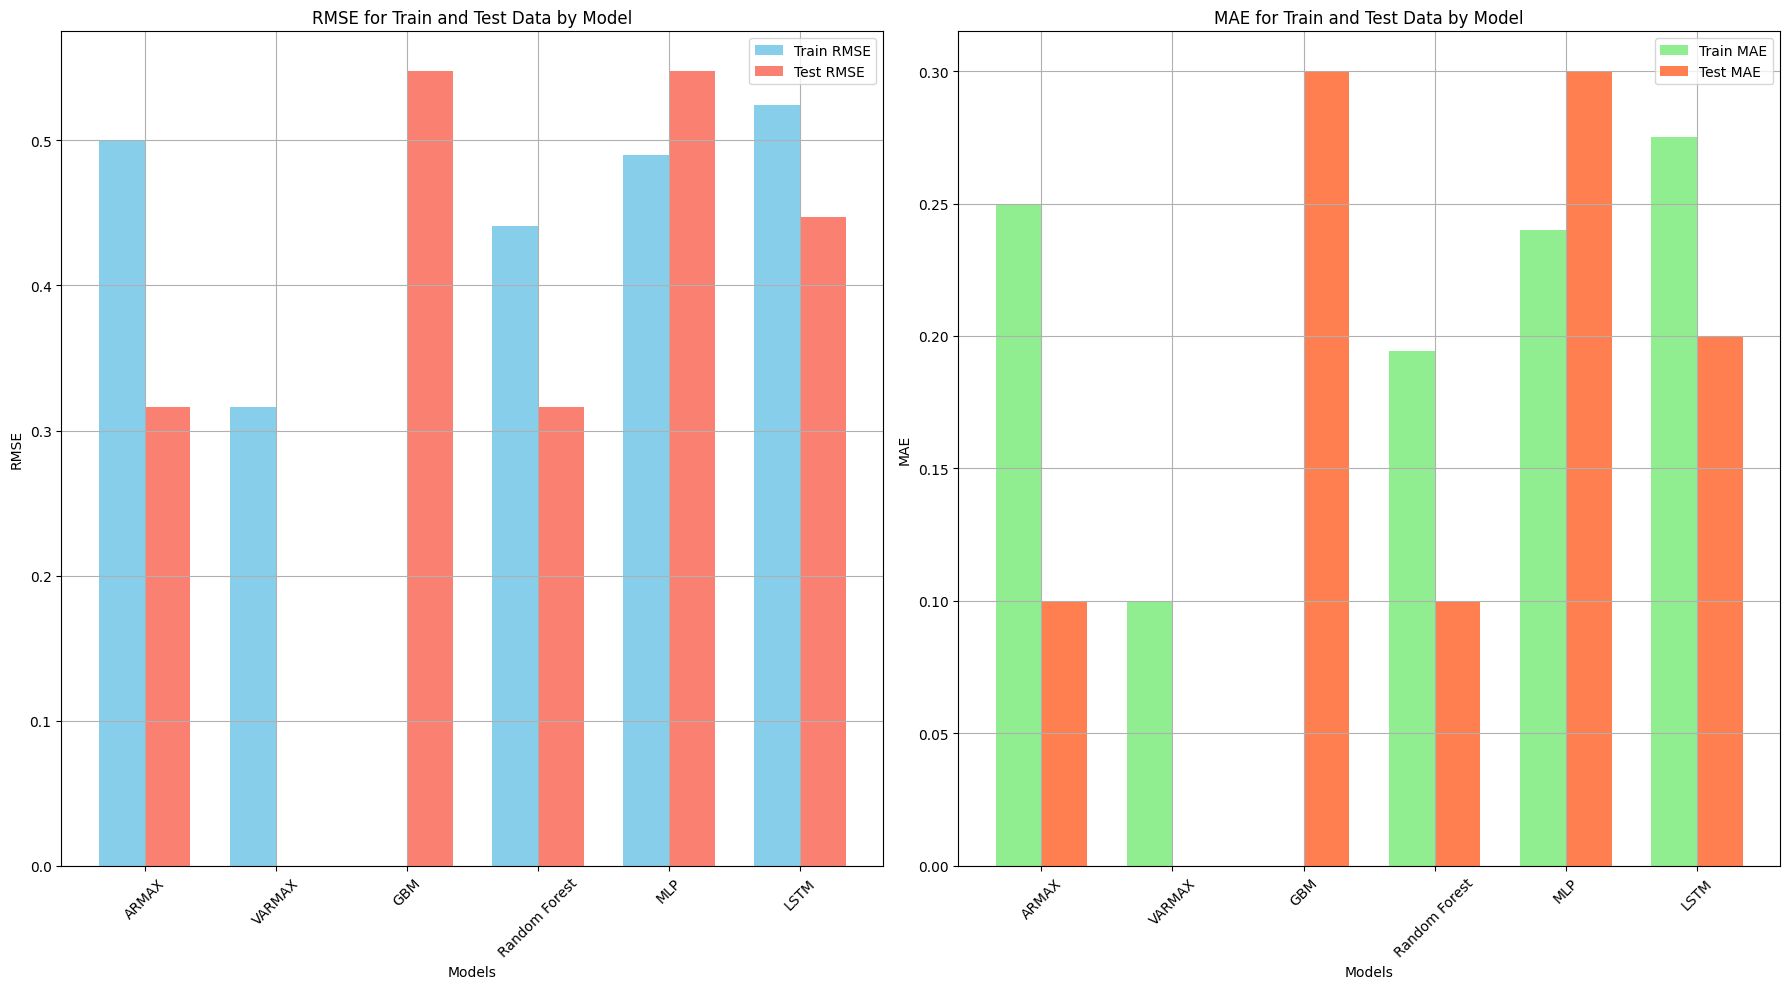

In [ ]:

models = ["ARMAX", "VARMAX", "GBM", "Random Forest", "MLP", "LSTM"]


train_rmse = [rmse_train_arima_2,rmse_train_varima_2,rmse_train_ensamble_2[0],rmse_train_ensamble_2[1],rmse_train_MLP_2,rmse_train_LSTM_2]
test_rmse = [rmse_test_arima_2,rmse_test_varima_2,rmse_test_ensamble_2[0],rmse_test_ensamble_2[1],rmse_test_MLP_2,rmse_test_LSTM_2]

train_mae = [mae_train_arima_2,mae_train_varima_2,mae_train_ensamble_2[0],mae_train_ensamble_2[1],mae_train_MLP_2,mae_train_LSTM_2]
test_mae = [mae_test_arima_2,mae_test_varima_2,mae_test_ensamble_2[0],mae_test_ensamble_2[1],mae_test_MLP_2,mae_test_LSTM_2]

x = np.arange(len(models))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(18, 10))

axs[0].bar(x - width/2, train_rmse, width, label='Train RMSE', color='skyblue')
axs[0].bar(x + width/2, test_rmse, width, label='Test RMSE', color='salmon')
axs[0].set_xlabel('Models')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE for Train and Test Data by Model')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45)
axs[0].legend()
axs[0].grid(True)

axs[1].bar(x - width/2, train_mae, width, label='Train MAE', color='lightgreen')
axs[1].bar(x + width/2, test_mae, width, label='Test MAE', color='coral')
axs[1].set_xlabel('Models')
axs[1].set_ylabel('MAE')
axs[1].set_title('MAE for Train and Test Data by Model')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Possiamo fare le stesse considerazioni anche per la variabile *Nuove catture per evento*, osservando che, per il set di allenamento, i valori migliori di **MSE** e **MAE** sono ottenuti dal modello **GBM**, mentre per il set di test, il modello **VARMAX** mostra le performance più elevate.

